In [1]:
# Install libraries for data_loader
!pip install pandas
!pip install sklearn
!pip install torchvision
!pip install tqdm
!pip install torchmetrics

In [2]:
# Import DataLoader and corresponding libraries
import pandas
import torchvision.transforms as TT
from torch.utils.data import DataLoader, Dataset, sampler
from sklearn.model_selection import StratifiedKFold
from torchvision import utils
from PIL import Image

In [3]:
# Import libraries for tensors
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
# For fbeta-score
from torchmetrics.functional import fbeta_score

In [5]:
# For model construction
from collections import OrderedDict

In [6]:
# Import tqdm for progress bar construction
import tqdm

In [7]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# Datatypes and Devices (from Assignment 2)
dtype = torch.float
ltype = torch.long

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:0


In [8]:
# Hyper-parameters for K-Fold Cross Validation
N = 5
seed = 42

torch.manual_seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(seed)

# Directories for Data
FF1010_Path = './data/'
AudioImage_Path = './image/'

In [9]:
# Call StratifiedKFold object
skf = StratifiedKFold(
    n_splits=5, shuffle=True, random_state=seed
)

In [10]:
# Modify dataframe for K-Fold Cross Validation (birdclef2021)
birdclef_csv = pandas.read_csv(AudioImage_Path + 'metadata.csv')
birdclef_csv.loc[birdclef_csv['label_id'] >= 0,'filepath'] = \
    AudioImage_Path + birdclef_csv.query('label_id >= 0')['primary_label'] + '/' + \
    birdclef_csv.query('label_id >= 0')['filename'] + '.npy'

birdclef_csv = birdclef_csv.dropna()
birdclef_csv = birdclef_csv.reset_index(drop=True)

# Add 'fold' attribute for dataset classification
birdclef_dataframe = birdclef_csv.copy()
for n, (_, nth_groups) in enumerate(
    skf.split(birdclef_dataframe, birdclef_dataframe['label_id'])):
    birdclef_dataframe.loc[nth_groups, 'fold'] = int(n)

In [11]:
# Class for ff1010 dataset
class birdclef(Dataset):
    def __init__(self, dataframe, process='train', labels='label_id'):
        self.dataframe = dataframe
        self.filepaths = dataframe['filepath'].values
        self.labels = dataframe[labels].values
        self.process = process
        self.batch_threshold = 64
        
        # Transforms for each train and validation
        self.train_transform = TT.Compose([
            TT.Resize([128, 281]),
            TT.RandomHorizontalFlip(p=0.5),
            TT.RandomVerticalFlip(p=0.5),
            TT.ToTensor(),
            TT.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
        self.val_transform = TT.Compose([
            TT.Resize([128, 281]),
            TT.ToTensor(),
            TT.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
    
    def __getitem__(self, idx):
        source = np.load(self.filepaths[idx])
        
        # Rearrange numpy arrays
        source = source.transpose(1, 2, 0)
        
        # Add RGB dimension
        source = np.stack((np.squeeze(source), ) * 3, -1)
        if len(source.shape) == 3:
            source = np.expand_dims(source, axis=2)
        source = source.transpose(2, 0, 1, 3)
        N, H, W, C = source.shape
        label_rp = N
        
        # Apply transform
        if self.process == 'train':
            source = torch.stack([self.train_transform(Image.fromarray(x)) for x in source])
        elif self.process == 'valid':
            source = torch.stack([self.val_transform(Image.fromarray(x)) for x in source])
        
        # Avoid CUDA OOM
        if N > self.batch_threshold:
            unit = (N - self.batch_threshold) // 2
            label_rp = self.batch_threshold
            if N % 2 == 0:
                source = source[unit : -unit]
            else:
                source = source[unit : -(unit + 1)]
        
        return source, torch.tensor(self.labels[idx], dtype=ltype).repeat(label_rp)
    
    def __len__(self):
        return len(self.dataframe)

This function evaluates model.

In [12]:
def evaluate_model(loader, model, beta=1.0):
    print("Checking accuracy score on validation set.")
    # TODO: extend this so that we can print that we evaluate test set.
    num_correct = 0
    num_samples = 0
    log_sum = 0
    fbeta_sum = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float)
            y = y.to(device=device, dtype=torch.long)
            y = torch.squeeze(y, 0)
            scores = model(torch.squeeze(x, 0))
            # scores means classfication class for each class. It should be the tensor with size of (Input size, Number of classes)

            # Checks naive accuracy.
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)

            # Checks Log Loss.
            log_loss = F.cross_entropy(scores, y)
            log_sum += log_loss.sum() * preds.size(0)

            # Checks Fbeta-score.
            fbeta = fbeta_score(preds, y, beta=beta)
            fbeta_sum += fbeta * preds.size(0)
            
            # Erase memory caches
            del x, y, scores, log_loss
        
        acc = float(num_correct) / num_samples
        log_score = log_sum / num_samples
        f_score = fbeta_sum / num_samples
        print('\nAccuracy: %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        print('Log Loss score:\t%.2f' % (log_score))
        print('Fbeta-score (beta=%d): \t%.2f' % (beta , f_score))
    return acc, log_score, f_score

Let's train with model 2.

In [13]:
import os

# Print period for accuracy.
print_period = 1000

# Hyper-parameters for training 
birdclef_batch = 1
birdclef_epoch = 30

# Learning Rate.
learning_rate_2 = 0.0001

# L2 Regularization Hyperparamter
weight_decay_2 = 0.01

# Beta constant for Fbeta-score.
# If you want to give more weight to precision, use value smaller than 1.0.
# If you want to give more weight to recall, use value larger than 1.0.
beta = 1.0

# Prototype of model 2.
# ResNet50 outputs (Batchsize, 1000) tensor as output, so we reduce them to 397.
class Model2(nn.Module):
    def __init__(self, num_classes=397):
        super().__init__()
        self.resnet50 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).to(device)
        self.relu = nn.ReLU().to(device)
        self.linear = nn.Linear(1000, num_classes, bias=True).to(device)
    
    def forward (self, x):
        x = self.resnet50(x)
        x = self.relu(x)
        x = self.linear(x)
        return x

cur_model = Model2()
print(cur_model)

def checkpoint(model, optimizer, scheduler, train_losses, val_losses, log_scores, fbeta_scores, epoch):
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'log_scores': log_scores,
            'fbeta_scores': fbeta_scores,
            }, './bird_specificator.pt')

def train_model(model, train_loader, val_loader, optimizer, scheduler, beta=beta, epoch=birdclef_epoch, ckpt_enable=True):
    val_losses = []
    train_losses = []
    log_scores = []
    fbeta_scores = []
    
    loss = 0
    log_score = 0
    saved_epoch = -1
    
    # Load checkpoint
    if ckpt_enable and os.path.exists('./bird_specificator.pt'):
        ckpt = torch.load('./bird_specificator.pt')
        model.load_state_dict(ckpt['model_state_dict'])
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])
        scheduler.load_state_dict(ckpt['scheduler_state_dict'])
        train_losses = ckpt['train_losses']
        val_losses = ckpt['val_losses']
        log_scores = ckpt['log_scores']
        fbeta_scores = ckpt['fbeta_scores']
        saved_epoch = ckpt['epoch']
    
    for e in range(epoch):
        if e <= saved_epoch:
            continue
            
        epoch_losses = []
        print(f"Training model 2, epoch {e+1}")
        for index, (source, label) in enumerate(tqdm.tqdm(train_loader)):          
            x = source.to(device=device, dtype=torch.float)  # move to device, e.g. GPU
            y = label.to(device=device, dtype=torch.long)
            y = torch.squeeze(y, 0)

            scores = model(torch.squeeze(x, 0))
            loss = F.cross_entropy(scores, y) # Log loss for our project.

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

            # every print_period, print loss.
            if index % print_period == 0:
                print('Iteration %d, loss = %.4f' % (index, loss.item()))
                
            # Erase memory caches
            del source, label, x, y, scores, loss
            
        # Cosine LR Annealing Scheduler
        scheduler.step()
        
        # Append the score to lists
        acc, log_score, fbeta_score = evaluate_model(val_loader, model, beta=beta)
        val_losses.append(acc)
        train_losses.append(torch.tensor(sum(epoch_losses) / len(epoch_losses), dtype=dtype))
        log_scores.append(log_score)
        fbeta_scores.append(fbeta_score)
        
        # every epoch, save the model
        checkpoint(model, optimizer, scheduler, train_losses, val_losses, log_scores, fbeta_scores, e)

    return model, val_losses, train_losses, log_scores, fbeta_scores

Using cache found in C:\Users\youngrae/.cache\torch\hub\pytorch_vision_v0.10.0


Model2(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

In [14]:
# Train loop for bird specificator
def bird_train(model, train_dataframe, val_dataframe, test_dataframe):  
    train_data = birdclef(train_dataframe, process='train', labels='label_id')
    val_data = birdclef(val_dataframe, process='valid', labels='label_id')
    test_data = birdclef(test_dataframe, process='valid', labels='label_id')
    
    # Construct data loader for train and validation
    train_loader = DataLoader(train_data, batch_size=birdclef_batch,
                             sampler=sampler.SubsetRandomSampler(range(len(train_dataframe))), 
                             drop_last=True)
    val_loader = DataLoader(val_data, batch_size=birdclef_batch,
                             sampler=sampler.SubsetRandomSampler(range(len(val_dataframe))),
                             drop_last=False)
    test_loader = DataLoader(test_data, batch_size=birdclef_batch,
                              sampler=sampler.SubsetRandomSampler(range(len(test_dataframe))),
                              drop_last=False)
    
    optimizer = optim.SGD(model.parameters(), lr=learning_rate_2, weight_decay=weight_decay_2, momentum=0.5)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=birdclef_epoch, eta_min=1e-6)
    trained_model, val_losses, train_losses, log_scores, fbeta_scores = train_model(
        model, train_loader, val_loader, optimizer, scheduler, beta=beta)
    test_acc, test_log_score, test_fbeta_score = evaluate_model(test_loader, trained_model, beta=beta)
    
    return val_losses, train_losses, log_scores, fbeta_scores, [test_acc, test_log_score, test_fbeta_score]

In [15]:
# Train, Validate and Test for nocall detector
def bird(model, dataframe, val_index, test_index):
    
    # Check that validation fold is not same as test fold
    assert val_index != test_index, \
        'Validation and test should be done on different fold.'
    print('Test set : %d, Validation set : %d' % (test_index, val_index))
    
    train_dataframe = dataframe.query(
        'fold != ' + str(val_index) + ' and fold != ' + str(test_index) 
    ).reset_index(drop=True)
    val_dataframe = dataframe.query(
        'fold == ' + str(val_index) 
    ).reset_index(drop=False)
    test_dataframe = dataframe.query(
        'fold == ' + str(test_index) 
    ).reset_index(drop=False)
    
    val_losses, train_losses, log_scores, fbeta_scores, test_scores = bird_train(
        model, train_dataframe, val_dataframe, test_dataframe)

    return val_losses, train_losses, log_scores, fbeta_scores, test_scores

In [16]:
val_losses, train_losses, log_scores, fbeta_scores, test_scores = \
    bird(cur_model, birdclef_dataframe, 1, 0)
del cur_model

# for i in range(2, 5):
#     cur_model = Model2()
#     cv_losses, ctr_losses, cl_scores, cf_scores, cte_scores = nocall(cur_model, birdclef_dataframe, i, 0)
#     val_losses = torch.mean(torch.stack((torch.tensor(val_losses), torch.tensor(cv_losses))), dim=0)
#     train_losses = torch.mean(torch.stack((torch.tensor(train_losses), torch.tensor(ctr_losses))), dim=0)
#     log_scores = torch.mean(torch.stack((torch.tensor(log_scores), torch.tensor(cl_scores))), dim=0)
#     fbeta_scores = torch.mean(torch.stack((torch.tensor(fbeta_scores), torch.tensor(cf_scores))), dim=0)
#     for j in range(len(test_scores)):
#         test_scores[j] = torch.mean(torch.stack((torch.tensor(test_scores[j]), torch.tensor(cte_scores[j]))), dim=0)

Test set : 0, Validation set : 1
Training model 2, epoch 1


  0%|                                                                             | 3/37724 [00:08<22:45:33,  2.17s/it]

Iteration 0, loss = 6.1403


  3%|██                                                                           | 1002/37724 [01:34<44:04, 13.89it/s]

Iteration 1000, loss = 5.6438


  5%|████                                                                         | 2000/37724 [02:56<42:41, 13.95it/s]

Iteration 2000, loss = 5.7375


  8%|██████▏                                                                      | 3003/37724 [04:22<43:16, 13.37it/s]

Iteration 3000, loss = 5.3686


 11%|████████▏                                                                    | 4003/37724 [05:44<41:49, 13.44it/s]

Iteration 4000, loss = 6.7845


 13%|██████████▏                                                                  | 5002/37724 [07:04<36:35, 14.90it/s]

Iteration 5000, loss = 6.7181


 16%|████████████▎                                                                | 6002/37724 [08:33<44:57, 11.76it/s]

Iteration 6000, loss = 5.7085


 19%|██████████████▎                                                              | 7004/37724 [09:56<31:02, 16.49it/s]

Iteration 7000, loss = 5.2064


 21%|████████████████▎                                                            | 8004/37724 [11:21<34:52, 14.20it/s]

Iteration 8000, loss = 6.3850


 24%|██████████████████▎                                                          | 9002/37724 [12:47<38:28, 12.44it/s]

Iteration 9000, loss = 6.6863


 27%|████████████████████▏                                                       | 10004/37724 [14:11<31:03, 14.87it/s]

Iteration 10000, loss = 5.3522


 29%|██████████████████████▏                                                     | 11002/37724 [15:33<46:02,  9.67it/s]

Iteration 11000, loss = 5.0050


 32%|████████████████████████▏                                                   | 12002/37724 [16:56<29:50, 14.37it/s]

Iteration 12000, loss = 6.2124


 34%|██████████████████████████▏                                                 | 13002/37724 [18:18<50:27,  8.17it/s]

Iteration 13000, loss = 5.9270


 37%|████████████████████████████▏                                               | 14002/37724 [19:39<27:56, 14.15it/s]

Iteration 14000, loss = 5.9802


 40%|██████████████████████████████▏                                             | 15002/37724 [21:00<27:16, 13.89it/s]

Iteration 15000, loss = 5.8413


 42%|████████████████████████████████▏                                           | 16002/37724 [22:24<27:55, 12.96it/s]

Iteration 16000, loss = 6.7980


 45%|██████████████████████████████████▎                                         | 17004/37724 [23:45<25:38, 13.46it/s]

Iteration 17000, loss = 6.3202


 48%|████████████████████████████████████▎                                       | 18004/37724 [25:08<25:05, 13.10it/s]

Iteration 18000, loss = 6.8981


 50%|██████████████████████████████████████▎                                     | 19003/37724 [26:33<30:45, 10.14it/s]

Iteration 19000, loss = 6.5863


 53%|████████████████████████████████████████▎                                   | 20003/37724 [27:55<25:28, 11.59it/s]

Iteration 20000, loss = 5.9863


 56%|██████████████████████████████████████████▎                                 | 21002/37724 [29:22<18:20, 15.20it/s]

Iteration 21000, loss = 6.4038


 58%|████████████████████████████████████████████▎                               | 22003/37724 [30:42<17:11, 15.24it/s]

Iteration 22000, loss = 5.7217


 61%|██████████████████████████████████████████████▎                             | 23003/37724 [32:05<17:04, 14.37it/s]

Iteration 23000, loss = 6.0871


 64%|████████████████████████████████████████████████▎                           | 24002/37724 [33:29<22:14, 10.28it/s]

Iteration 24000, loss = 5.6237


 66%|██████████████████████████████████████████████████▎                         | 25003/37724 [34:51<13:21, 15.88it/s]

Iteration 25000, loss = 6.2853


 69%|████████████████████████████████████████████████████▍                       | 26002/37724 [36:14<12:38, 15.45it/s]

Iteration 26000, loss = 5.5576


 72%|██████████████████████████████████████████████████████▍                     | 27002/37724 [37:35<13:08, 13.59it/s]

Iteration 27000, loss = 5.6481


 74%|████████████████████████████████████████████████████████▍                   | 28003/37724 [38:57<11:32, 14.03it/s]

Iteration 28000, loss = 6.0046


 77%|██████████████████████████████████████████████████████████▍                 | 29002/37724 [40:18<09:37, 15.10it/s]

Iteration 29000, loss = 6.3267


 80%|████████████████████████████████████████████████████████████▍               | 30001/37724 [41:41<11:09, 11.53it/s]

Iteration 30000, loss = 5.9095


 82%|██████████████████████████████████████████████████████████████▍             | 31004/37724 [43:04<06:25, 17.43it/s]

Iteration 31000, loss = 5.9745


 85%|████████████████████████████████████████████████████████████████▍           | 32002/37724 [44:27<10:34,  9.01it/s]

Iteration 32000, loss = 5.2016


 87%|██████████████████████████████████████████████████████████████████▍         | 33004/37724 [45:54<05:53, 13.37it/s]

Iteration 33000, loss = 5.0165


 90%|████████████████████████████████████████████████████████████████████▌       | 34003/37724 [47:19<04:51, 12.76it/s]

Iteration 34000, loss = 6.3871


 93%|██████████████████████████████████████████████████████████████████████▌     | 35003/37724 [48:42<04:51,  9.34it/s]

Iteration 35000, loss = 6.3178


 95%|████████████████████████████████████████████████████████████████████████▌   | 36003/37724 [50:11<02:14, 12.83it/s]

Iteration 36000, loss = 6.5059


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37002/37724 [51:30<01:04, 11.17it/s]

Iteration 37000, loss = 5.9068


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [52:35<00:00, 11.95it/s]


Checking accuracy score on validation set.

Accuracy: 1157 / 131159 correct (0.88)
Log Loss score:	5.77
Fbeta-score (beta=1): 	0.01
Training model 2, epoch 2


  0%|                                                                              | 1/37724 [00:00<1:12:56,  8.62it/s]

Iteration 0, loss = 6.0492


  3%|██                                                                           | 1004/37724 [01:17<38:04, 16.07it/s]

Iteration 1000, loss = 6.0367


  5%|████                                                                         | 2002/37724 [02:36<50:31, 11.78it/s]

Iteration 2000, loss = 7.0768


  8%|██████▏                                                                      | 3002/37724 [03:52<43:26, 13.32it/s]

Iteration 3000, loss = 6.0502


 11%|████████▏                                                                    | 4002/37724 [05:09<38:08, 14.73it/s]

Iteration 4000, loss = 6.5684


 13%|██████████▏                                                                  | 5002/37724 [06:25<44:55, 12.14it/s]

Iteration 5000, loss = 6.6721


 16%|████████████▎                                                                | 6003/37724 [07:42<47:21, 11.16it/s]

Iteration 6000, loss = 5.0649


 19%|██████████████▎                                                              | 7004/37724 [08:57<36:10, 14.15it/s]

Iteration 7000, loss = 6.1959


 21%|████████████████▎                                                            | 8003/37724 [10:14<32:16, 15.35it/s]

Iteration 8000, loss = 6.6066


 24%|██████████████████▎                                                          | 9002/37724 [11:34<36:11, 13.23it/s]

Iteration 9000, loss = 6.5974


 27%|████████████████████▏                                                       | 10005/37724 [12:49<29:41, 15.56it/s]

Iteration 10000, loss = 4.9349


 29%|██████████████████████▏                                                     | 10999/37724 [14:03<41:35, 10.71it/s]

Iteration 11000, loss = 5.4412


 32%|████████████████████████▏                                                   | 12001/37724 [15:23<26:01, 16.47it/s]

Iteration 12000, loss = 5.6417


 34%|██████████████████████████▏                                                 | 13003/37724 [16:39<31:26, 13.11it/s]

Iteration 13000, loss = 6.6138


 37%|████████████████████████████▏                                               | 14002/37724 [17:53<33:50, 11.68it/s]

Iteration 14000, loss = 5.4203


 40%|██████████████████████████████▏                                             | 15003/37724 [19:10<25:31, 14.83it/s]

Iteration 15000, loss = 6.3545


 42%|████████████████████████████████▏                                           | 16003/37724 [20:26<22:11, 16.32it/s]

Iteration 16000, loss = 5.4039


 45%|██████████████████████████████████▎                                         | 17003/37724 [21:40<21:00, 16.44it/s]

Iteration 17000, loss = 6.5193


 48%|████████████████████████████████████▎                                       | 18004/37724 [23:00<23:39, 13.90it/s]

Iteration 18000, loss = 6.8939


 50%|██████████████████████████████████████▎                                     | 19002/37724 [24:14<24:02, 12.98it/s]

Iteration 19000, loss = 5.0590


 53%|████████████████████████████████████████▎                                   | 20005/37724 [25:28<21:37, 13.66it/s]

Iteration 20000, loss = 2.9586


 56%|██████████████████████████████████████████▎                                 | 21000/37724 [26:40<20:25, 13.65it/s]

Iteration 21000, loss = 6.2288


 58%|████████████████████████████████████████████▎                               | 22001/37724 [27:58<17:54, 14.64it/s]

Iteration 22000, loss = 4.8008


 61%|██████████████████████████████████████████████▎                             | 23004/37724 [29:15<18:47, 13.05it/s]

Iteration 23000, loss = 6.8128


 64%|████████████████████████████████████████████████▎                           | 24002/37724 [30:35<15:48, 14.47it/s]

Iteration 24000, loss = 6.2512


 66%|██████████████████████████████████████████████████▎                         | 25004/37724 [31:52<16:16, 13.03it/s]

Iteration 25000, loss = 5.8683


 69%|████████████████████████████████████████████████████▍                       | 26004/37724 [33:08<15:00, 13.02it/s]

Iteration 26000, loss = 4.7074


 72%|██████████████████████████████████████████████████████▍                     | 27001/37724 [34:27<16:55, 10.56it/s]

Iteration 27000, loss = 5.8107


 74%|████████████████████████████████████████████████████████▍                   | 28004/37724 [35:50<12:46, 12.68it/s]

Iteration 28000, loss = 3.0117


 77%|██████████████████████████████████████████████████████████▍                 | 29003/37724 [37:07<09:19, 15.59it/s]

Iteration 29000, loss = 6.0643


 80%|████████████████████████████████████████████████████████████▍               | 30003/37724 [38:24<07:29, 17.18it/s]

Iteration 30000, loss = 5.2341


 82%|██████████████████████████████████████████████████████████████▍             | 31002/37724 [39:41<10:41, 10.49it/s]

Iteration 31000, loss = 6.7519


 85%|████████████████████████████████████████████████████████████████▍           | 32005/37724 [40:55<05:42, 16.68it/s]

Iteration 32000, loss = 5.6504


 87%|██████████████████████████████████████████████████████████████████▍         | 33004/37724 [42:11<04:17, 18.31it/s]

Iteration 33000, loss = 0.6020


 90%|████████████████████████████████████████████████████████████████████▌       | 34004/37724 [43:24<04:40, 13.27it/s]

Iteration 34000, loss = 6.1654


 93%|██████████████████████████████████████████████████████████████████████▌     | 35001/37724 [44:43<03:39, 12.40it/s]

Iteration 35000, loss = 4.6464


 95%|████████████████████████████████████████████████████████████████████████▌   | 36003/37724 [45:58<01:31, 18.86it/s]

Iteration 36000, loss = 5.4776


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37002/37724 [47:11<01:08, 10.55it/s]

Iteration 37000, loss = 3.5035


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [48:07<00:00, 13.07it/s]


Checking accuracy score on validation set.

Accuracy: 19213 / 131159 correct (14.65)
Log Loss score:	4.39
Fbeta-score (beta=1): 	0.15
Training model 2, epoch 3


  0%|                                                                                | 2/37724 [00:00<32:41, 19.23it/s]

Iteration 0, loss = 5.3316


  3%|██                                                                           | 1003/37724 [01:18<44:48, 13.66it/s]

Iteration 1000, loss = 2.3798


  5%|████                                                                         | 2004/37724 [02:35<33:03, 18.01it/s]

Iteration 2000, loss = 4.1967


  8%|██████▏                                                                      | 3003/37724 [03:51<57:18, 10.10it/s]

Iteration 3000, loss = 4.7862


 11%|████████▏                                                                    | 4002/37724 [05:06<42:21, 13.27it/s]

Iteration 4000, loss = 5.8966


 13%|██████████▏                                                                  | 5003/37724 [06:25<38:19, 14.23it/s]

Iteration 5000, loss = 3.4062


 16%|████████████▎                                                                | 6003/37724 [07:39<35:00, 15.10it/s]

Iteration 6000, loss = 2.6353


 19%|██████████████▎                                                              | 7002/37724 [08:54<32:39, 15.68it/s]

Iteration 7000, loss = 4.6013


 21%|████████████████▎                                                            | 8003/37724 [10:12<31:16, 15.84it/s]

Iteration 8000, loss = 5.7958


 24%|██████████████████▍                                                          | 9005/37724 [11:28<31:47, 15.06it/s]

Iteration 9000, loss = 5.7358


 27%|████████████████████▏                                                       | 10002/37724 [12:40<27:31, 16.79it/s]

Iteration 10000, loss = 2.6472


 29%|██████████████████████▏                                                     | 11004/37724 [13:58<31:42, 14.05it/s]

Iteration 11000, loss = 3.8819


 32%|████████████████████████▏                                                   | 12002/37724 [15:14<42:01, 10.20it/s]

Iteration 12000, loss = 3.2537


 34%|██████████████████████████▏                                                 | 13004/37724 [16:30<36:51, 11.18it/s]

Iteration 13000, loss = 8.4883


 37%|████████████████████████████▏                                               | 14003/37724 [17:48<26:15, 15.06it/s]

Iteration 14000, loss = 1.9355


 40%|██████████████████████████████▏                                             | 15003/37724 [19:07<25:04, 15.10it/s]

Iteration 15000, loss = 4.8722


 42%|████████████████████████████████▏                                           | 16002/37724 [20:21<22:52, 15.83it/s]

Iteration 16000, loss = 4.9165


 45%|██████████████████████████████████▎                                         | 17002/37724 [21:35<28:42, 12.03it/s]

Iteration 17000, loss = 0.3666


 48%|████████████████████████████████████▎                                       | 18005/37724 [22:50<21:58, 14.95it/s]

Iteration 18000, loss = 3.0041


 50%|██████████████████████████████████████▎                                     | 19004/37724 [24:04<22:41, 13.75it/s]

Iteration 19000, loss = 5.6639


 53%|████████████████████████████████████████▎                                   | 20002/37724 [25:22<29:44,  9.93it/s]

Iteration 20000, loss = 1.5789


 56%|██████████████████████████████████████████▎                                 | 21003/37724 [26:38<17:37, 15.81it/s]

Iteration 21000, loss = 8.8765


 58%|████████████████████████████████████████████▎                               | 22002/37724 [27:52<27:26,  9.55it/s]

Iteration 22000, loss = 6.3884


 61%|██████████████████████████████████████████████▎                             | 23002/37724 [29:04<14:21, 17.10it/s]

Iteration 23000, loss = 2.4211


 64%|████████████████████████████████████████████████▎                           | 24002/37724 [30:20<27:32,  8.31it/s]

Iteration 24000, loss = 4.5438


 66%|██████████████████████████████████████████████████▎                         | 25002/37724 [31:37<15:22, 13.79it/s]

Iteration 25000, loss = 1.8648


 69%|████████████████████████████████████████████████████▍                       | 26003/37724 [32:51<13:42, 14.25it/s]

Iteration 26000, loss = 3.6426


 72%|██████████████████████████████████████████████████████▍                     | 27005/37724 [34:07<14:24, 12.40it/s]

Iteration 27000, loss = 7.6987


 74%|████████████████████████████████████████████████████████▍                   | 28002/37724 [35:24<11:04, 14.62it/s]

Iteration 28000, loss = 1.1293


 77%|██████████████████████████████████████████████████████████▍                 | 29001/37724 [36:38<12:30, 11.62it/s]

Iteration 29000, loss = 3.9737


 80%|████████████████████████████████████████████████████████████▍               | 30003/37724 [37:53<07:34, 17.00it/s]

Iteration 30000, loss = 3.9278


 82%|██████████████████████████████████████████████████████████████▍             | 31003/37724 [39:10<07:54, 14.17it/s]

Iteration 31000, loss = 1.1783


 85%|████████████████████████████████████████████████████████████████▍           | 32002/37724 [40:28<05:58, 15.94it/s]

Iteration 32000, loss = 3.1428


 87%|██████████████████████████████████████████████████████████████████▍         | 33004/37724 [41:50<05:30, 14.29it/s]

Iteration 33000, loss = 1.5615


 90%|████████████████████████████████████████████████████████████████████▌       | 34002/37724 [43:06<03:35, 17.24it/s]

Iteration 34000, loss = 6.3061


 93%|██████████████████████████████████████████████████████████████████████▌     | 35002/37724 [44:19<03:14, 14.03it/s]

Iteration 35000, loss = 0.2610


 95%|████████████████████████████████████████████████████████████████████████▌   | 36002/37724 [45:38<01:23, 20.53it/s]

Iteration 36000, loss = 2.8689


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37005/37724 [46:56<00:38, 18.68it/s]

Iteration 37000, loss = 1.7473


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [47:49<00:00, 13.14it/s]


Checking accuracy score on validation set.

Accuracy: 39935 / 131159 correct (30.45)
Log Loss score:	3.43
Fbeta-score (beta=1): 	0.30
Training model 2, epoch 4


  0%|                                                                              | 1/37724 [00:00<1:07:53,  9.26it/s]

Iteration 0, loss = 3.2233


  3%|██                                                                           | 1003/37724 [01:16<36:26, 16.80it/s]

Iteration 1000, loss = 5.6532


  5%|████                                                                         | 2003/37724 [02:34<39:03, 15.24it/s]

Iteration 2000, loss = 4.2496


  8%|██████▏                                                                      | 3002/37724 [03:55<47:10, 12.27it/s]

Iteration 3000, loss = 0.9322


 11%|████████▏                                                                    | 4003/37724 [05:11<27:55, 20.12it/s]

Iteration 4000, loss = 5.8511


 13%|██████████▏                                                                  | 5002/37724 [06:26<32:31, 16.77it/s]

Iteration 5000, loss = 1.5300


 16%|████████████▎                                                                | 6003/37724 [07:45<32:45, 16.14it/s]

Iteration 6000, loss = 3.8456


 19%|██████████████▎                                                              | 7003/37724 [09:00<39:29, 12.96it/s]

Iteration 7000, loss = 2.6957


 21%|████████████████▎                                                            | 8003/37724 [10:17<37:01, 13.38it/s]

Iteration 8000, loss = 3.0849


 24%|██████████████████▎                                                          | 9001/37724 [11:34<34:31, 13.86it/s]

Iteration 9000, loss = 2.0611


 27%|████████████████████▏                                                       | 10003/37724 [12:48<32:26, 14.24it/s]

Iteration 10000, loss = 3.6482


 29%|██████████████████████▏                                                     | 11002/37724 [14:00<41:40, 10.68it/s]

Iteration 11000, loss = 3.9963


 32%|████████████████████████▏                                                   | 12003/37724 [15:19<27:35, 15.54it/s]

Iteration 12000, loss = 3.8393


 34%|██████████████████████████▏                                                 | 13001/37724 [16:40<33:28, 12.31it/s]

Iteration 13000, loss = 4.5006


 37%|████████████████████████████▏                                               | 14003/37724 [17:58<27:07, 14.57it/s]

Iteration 14000, loss = 6.6299


 40%|██████████████████████████████▏                                             | 15002/37724 [19:14<39:25,  9.60it/s]

Iteration 15000, loss = 2.4815


 42%|████████████████████████████████▏                                           | 16002/37724 [20:32<29:22, 12.32it/s]

Iteration 16000, loss = 2.0560


 45%|██████████████████████████████████▎                                         | 17003/37724 [21:52<25:39, 13.46it/s]

Iteration 17000, loss = 5.2157


 48%|████████████████████████████████████▎                                       | 18003/37724 [23:12<32:34, 10.09it/s]

Iteration 18000, loss = 0.5435


 50%|██████████████████████████████████████▎                                     | 19005/37724 [24:27<26:06, 11.95it/s]

Iteration 19000, loss = 0.3459


 53%|████████████████████████████████████████▎                                   | 20002/37724 [25:42<20:51, 14.16it/s]

Iteration 20000, loss = 4.0377


 56%|██████████████████████████████████████████▎                                 | 21002/37724 [26:57<23:00, 12.11it/s]

Iteration 21000, loss = 0.2101


 58%|████████████████████████████████████████████▎                               | 22003/37724 [28:17<16:52, 15.53it/s]

Iteration 22000, loss = 0.5457


 61%|██████████████████████████████████████████████▎                             | 23004/37724 [29:32<15:22, 15.96it/s]

Iteration 23000, loss = 6.8930


 64%|████████████████████████████████████████████████▎                           | 24004/37724 [30:47<12:06, 18.90it/s]

Iteration 24000, loss = 1.2421


 66%|██████████████████████████████████████████████████▎                         | 25003/37724 [32:03<12:43, 16.66it/s]

Iteration 25000, loss = 4.9231


 69%|████████████████████████████████████████████████████▍                       | 26003/37724 [33:21<12:39, 15.43it/s]

Iteration 26000, loss = 1.0535


 72%|██████████████████████████████████████████████████████▍                     | 27003/37724 [34:39<10:38, 16.80it/s]

Iteration 27000, loss = 2.3271


 74%|████████████████████████████████████████████████████████▍                   | 28005/37724 [35:58<14:25, 11.23it/s]

Iteration 28000, loss = 5.5245


 77%|██████████████████████████████████████████████████████████▍                 | 29002/37724 [37:20<10:30, 13.84it/s]

Iteration 29000, loss = 0.8936


 80%|████████████████████████████████████████████████████████████▍               | 30002/37724 [38:43<11:53, 10.82it/s]

Iteration 30000, loss = 4.2061


 82%|██████████████████████████████████████████████████████████████▍             | 31002/37724 [40:03<07:05, 15.79it/s]

Iteration 31000, loss = 2.0049


 85%|████████████████████████████████████████████████████████████████▍           | 32003/37724 [41:21<08:07, 11.74it/s]

Iteration 32000, loss = 1.0270


 87%|██████████████████████████████████████████████████████████████████▍         | 33003/37724 [42:38<04:58, 15.81it/s]

Iteration 33000, loss = 5.6921


 90%|████████████████████████████████████████████████████████████████████▌       | 34002/37724 [43:56<03:57, 15.68it/s]

Iteration 34000, loss = 2.1013


 93%|██████████████████████████████████████████████████████████████████████▌     | 35004/37724 [45:16<02:41, 16.84it/s]

Iteration 35000, loss = 3.6735


 95%|████████████████████████████████████████████████████████████████████████▌   | 36005/37724 [46:34<01:59, 14.43it/s]

Iteration 36000, loss = 0.0008


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37003/37724 [47:51<00:43, 16.46it/s]

Iteration 37000, loss = 0.6773


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [48:50<00:00, 12.88it/s]


Checking accuracy score on validation set.

Accuracy: 45434 / 131159 correct (34.64)
Log Loss score:	3.17
Fbeta-score (beta=1): 	0.35
Training model 2, epoch 5


  0%|                                                                              | 1/37724 [00:00<1:24:52,  7.41it/s]

Iteration 0, loss = 2.1793


  3%|██                                                                           | 1002/37724 [01:20<40:51, 14.98it/s]

Iteration 1000, loss = 0.0560


  5%|████                                                                         | 2004/37724 [02:38<50:29, 11.79it/s]

Iteration 2000, loss = 6.6786


  8%|██████▏                                                                      | 3004/37724 [03:54<39:43, 14.57it/s]

Iteration 3000, loss = 3.5857


 11%|████████▏                                                                    | 4002/37724 [05:06<39:02, 14.40it/s]

Iteration 4000, loss = 1.0900


 13%|██████████▏                                                                  | 4999/37724 [06:23<42:23, 12.87it/s]

Iteration 5000, loss = 4.1026


 16%|████████████▎                                                                | 6002/37724 [07:39<42:53, 12.33it/s]

Iteration 6000, loss = 3.2055


 19%|██████████████▎                                                              | 7005/37724 [08:54<29:59, 17.07it/s]

Iteration 7000, loss = 4.1701


 21%|████████████████▎                                                            | 8005/37724 [10:10<33:34, 14.75it/s]

Iteration 8000, loss = 4.4187


 24%|██████████████████▎                                                          | 9002/37724 [11:26<38:03, 12.58it/s]

Iteration 9000, loss = 3.1471


 27%|████████████████████▏                                                       | 10003/37724 [12:43<29:57, 15.43it/s]

Iteration 10000, loss = 5.6049


 29%|██████████████████████▏                                                     | 11003/37724 [14:01<35:51, 12.42it/s]

Iteration 11000, loss = 2.1837


 32%|████████████████████████▏                                                   | 12002/37724 [15:18<34:55, 12.28it/s]

Iteration 12000, loss = 0.4209


 34%|██████████████████████████▏                                                 | 13002/37724 [16:34<30:11, 13.65it/s]

Iteration 13000, loss = 1.1309


 37%|████████████████████████████▏                                               | 14004/37724 [17:51<24:00, 16.47it/s]

Iteration 14000, loss = 3.3503


 40%|██████████████████████████████▏                                             | 15003/37724 [19:07<21:22, 17.71it/s]

Iteration 15000, loss = 0.2711


 42%|████████████████████████████████▏                                           | 16003/37724 [20:24<20:28, 17.69it/s]

Iteration 16000, loss = 0.0440


 45%|██████████████████████████████████▎                                         | 17003/37724 [21:45<24:00, 14.38it/s]

Iteration 17000, loss = 2.6727


 48%|████████████████████████████████████▎                                       | 18002/37724 [23:01<23:51, 13.77it/s]

Iteration 18000, loss = 2.0664


 50%|██████████████████████████████████████▎                                     | 19003/37724 [24:15<29:06, 10.72it/s]

Iteration 19000, loss = 5.3779


 53%|████████████████████████████████████████▎                                   | 20003/37724 [25:32<21:59, 13.43it/s]

Iteration 20000, loss = 3.0750


 56%|██████████████████████████████████████████▎                                 | 21003/37724 [26:51<21:45, 12.81it/s]

Iteration 21000, loss = 2.3588


 58%|████████████████████████████████████████████▎                               | 22004/37724 [28:07<18:15, 14.35it/s]

Iteration 22000, loss = 0.6681


 61%|██████████████████████████████████████████████▎                             | 23005/37724 [29:27<12:10, 20.15it/s]

Iteration 23000, loss = 0.2685


 64%|████████████████████████████████████████████████▎                           | 24003/37724 [30:44<22:46, 10.04it/s]

Iteration 24000, loss = 3.5152


 66%|██████████████████████████████████████████████████▎                         | 25003/37724 [31:59<12:32, 16.90it/s]

Iteration 25000, loss = 6.3232


 69%|████████████████████████████████████████████████████▍                       | 26003/37724 [33:16<13:37, 14.35it/s]

Iteration 26000, loss = 5.4732


 72%|██████████████████████████████████████████████████████▍                     | 27000/37724 [34:30<11:55, 14.99it/s]

Iteration 27000, loss = 4.3697


 74%|████████████████████████████████████████████████████████▍                   | 28003/37724 [35:45<15:16, 10.61it/s]

Iteration 28000, loss = 3.6220


 77%|██████████████████████████████████████████████████████████▍                 | 29004/37724 [37:04<08:33, 16.97it/s]

Iteration 29000, loss = 2.9087


 80%|████████████████████████████████████████████████████████████▍               | 30001/37724 [38:20<07:41, 16.74it/s]

Iteration 30000, loss = 8.2302


 82%|██████████████████████████████████████████████████████████████▍             | 31002/37724 [39:39<09:28, 11.83it/s]

Iteration 31000, loss = 4.4070


 85%|████████████████████████████████████████████████████████████████▍           | 32003/37724 [40:57<07:02, 13.54it/s]

Iteration 32000, loss = 3.8899


 87%|██████████████████████████████████████████████████████████████████▍         | 33003/37724 [42:14<04:59, 15.79it/s]

Iteration 33000, loss = 0.9362


 90%|████████████████████████████████████████████████████████████████████▌       | 34004/37724 [43:33<04:36, 13.47it/s]

Iteration 34000, loss = 1.6162


 93%|██████████████████████████████████████████████████████████████████████▌     | 35004/37724 [44:51<03:12, 14.14it/s]

Iteration 35000, loss = 1.6444


 95%|████████████████████████████████████████████████████████████████████████▌   | 36004/37724 [46:10<02:00, 14.22it/s]

Iteration 36000, loss = 3.8348


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37002/37724 [47:28<01:05, 10.96it/s]

Iteration 37000, loss = 2.4368


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [48:27<00:00, 12.98it/s]


Checking accuracy score on validation set.

Accuracy: 49617 / 131159 correct (37.83)
Log Loss score:	3.00
Fbeta-score (beta=1): 	0.38
Training model 2, epoch 6


  0%|                                                                              | 1/37724 [00:00<1:14:11,  8.47it/s]

Iteration 0, loss = 0.0203


  3%|██                                                                           | 1005/37724 [01:16<37:36, 16.27it/s]

Iteration 1000, loss = 1.6385


  5%|████                                                                         | 2005/37724 [02:31<45:38, 13.04it/s]

Iteration 2000, loss = 1.5463


  8%|██████▏                                                                      | 3001/37724 [03:44<39:33, 14.63it/s]

Iteration 3000, loss = 3.6013


 11%|████████▏                                                                    | 4002/37724 [05:03<55:12, 10.18it/s]

Iteration 4000, loss = 2.5430


 13%|██████████▏                                                                  | 5004/37724 [06:20<30:46, 17.72it/s]

Iteration 5000, loss = 2.8142


 16%|████████████▎                                                                | 6002/37724 [07:36<36:57, 14.30it/s]

Iteration 6000, loss = 4.7186


 19%|██████████████▎                                                              | 6999/37724 [08:53<54:41,  9.36it/s]

Iteration 7000, loss = 2.2882


 21%|████████████████▎                                                            | 8003/37724 [10:12<35:57, 13.77it/s]

Iteration 8000, loss = 0.1666


 24%|██████████████████▎                                                          | 9002/37724 [11:30<42:33, 11.25it/s]

Iteration 9000, loss = 1.6159


 27%|████████████████████▏                                                       | 10005/37724 [12:49<33:29, 13.79it/s]

Iteration 10000, loss = 1.3425


 29%|██████████████████████▏                                                     | 11003/37724 [14:08<25:21, 17.56it/s]

Iteration 11000, loss = 4.1307


 32%|████████████████████████▏                                                   | 12003/37724 [15:27<31:21, 13.67it/s]

Iteration 12000, loss = 2.3239


 34%|██████████████████████████▏                                                 | 13002/37724 [16:42<24:51, 16.58it/s]

Iteration 13000, loss = 0.6864


 37%|████████████████████████████▏                                               | 14003/37724 [17:53<20:29, 19.30it/s]

Iteration 14000, loss = 0.0837


 40%|██████████████████████████████▏                                             | 15005/37724 [19:11<22:24, 16.90it/s]

Iteration 15000, loss = 0.5872


 42%|████████████████████████████████▏                                           | 16004/37724 [20:26<23:11, 15.61it/s]

Iteration 16000, loss = 0.2450


 45%|██████████████████████████████████▎                                         | 17003/37724 [21:41<30:49, 11.21it/s]

Iteration 17000, loss = 1.9295


 48%|████████████████████████████████████▎                                       | 18004/37724 [22:56<18:25, 17.84it/s]

Iteration 18000, loss = 0.5300


 50%|██████████████████████████████████████▎                                     | 19000/37724 [24:11<28:43, 10.87it/s]

Iteration 19000, loss = 3.3807


 53%|████████████████████████████████████████▎                                   | 20002/37724 [25:26<19:21, 15.26it/s]

Iteration 20000, loss = 6.1464


 56%|██████████████████████████████████████████▎                                 | 21004/37724 [26:44<18:21, 15.18it/s]

Iteration 21000, loss = 2.0185


 58%|████████████████████████████████████████████▎                               | 22003/37724 [28:02<20:11, 12.97it/s]

Iteration 22000, loss = 5.8866


 61%|██████████████████████████████████████████████▎                             | 23003/37724 [29:15<15:12, 16.13it/s]

Iteration 23000, loss = 1.5964


 64%|████████████████████████████████████████████████▎                           | 24002/37724 [30:29<22:34, 10.13it/s]

Iteration 24000, loss = 5.9652


 66%|██████████████████████████████████████████████████▎                         | 25002/37724 [31:45<17:08, 12.37it/s]

Iteration 25000, loss = 0.6250


 69%|████████████████████████████████████████████████████▍                       | 26002/37724 [33:01<19:20, 10.10it/s]

Iteration 26000, loss = 0.8969


 72%|██████████████████████████████████████████████████████▍                     | 27001/37724 [34:16<13:50, 12.90it/s]

Iteration 27000, loss = 3.0984


 74%|████████████████████████████████████████████████████████▍                   | 28003/37724 [35:32<12:03, 13.43it/s]

Iteration 28000, loss = 1.9601


 77%|██████████████████████████████████████████████████████████▍                 | 29004/37724 [36:47<09:16, 15.67it/s]

Iteration 29000, loss = 0.4899


 80%|████████████████████████████████████████████████████████████▍               | 30003/37724 [38:04<08:29, 15.16it/s]

Iteration 30000, loss = 4.7906


 82%|██████████████████████████████████████████████████████████████▍             | 31000/37724 [39:18<07:35, 14.76it/s]

Iteration 31000, loss = 2.1023


 85%|████████████████████████████████████████████████████████████████▍           | 32001/37724 [40:34<06:00, 15.90it/s]

Iteration 32000, loss = 1.0808


 87%|██████████████████████████████████████████████████████████████████▍         | 33003/37724 [41:49<06:42, 11.72it/s]

Iteration 33000, loss = 4.1028


 90%|████████████████████████████████████████████████████████████████████▌       | 34003/37724 [43:07<04:36, 13.43it/s]

Iteration 34000, loss = 6.0468


 93%|██████████████████████████████████████████████████████████████████████▌     | 35002/37724 [44:23<02:22, 19.11it/s]

Iteration 35000, loss = 0.1290


 95%|████████████████████████████████████████████████████████████████████████▌   | 36003/37724 [45:38<02:12, 12.99it/s]

Iteration 36000, loss = 3.7338


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37001/37724 [46:52<00:49, 14.67it/s]

Iteration 37000, loss = 0.1799


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [47:48<00:00, 13.15it/s]


Checking accuracy score on validation set.

Accuracy: 56747 / 131159 correct (43.27)
Log Loss score:	2.74
Fbeta-score (beta=1): 	0.43
Training model 2, epoch 7


  0%|                                                                                | 2/37724 [00:00<55:01, 11.43it/s]

Iteration 0, loss = 1.7600


  3%|██                                                                           | 1002/37724 [01:15<59:16, 10.33it/s]

Iteration 1000, loss = 0.0206


  5%|████                                                                         | 2002/37724 [02:30<43:10, 13.79it/s]

Iteration 2000, loss = 2.8334


  8%|██████▏                                                                      | 3001/37724 [03:47<53:37, 10.79it/s]

Iteration 3000, loss = 1.3963


 11%|████████▏                                                                    | 4001/37724 [05:03<32:30, 17.29it/s]

Iteration 4000, loss = 3.4774


 13%|██████████▏                                                                  | 5002/37724 [06:19<37:30, 14.54it/s]

Iteration 5000, loss = 0.4008


 16%|████████████▎                                                                | 6002/37724 [07:32<50:35, 10.45it/s]

Iteration 6000, loss = 3.0170


 19%|██████████████▎                                                              | 7005/37724 [08:51<34:22, 14.89it/s]

Iteration 7000, loss = 3.4030


 21%|████████████████▎                                                            | 8003/37724 [10:09<45:14, 10.95it/s]

Iteration 8000, loss = 2.3681


 24%|██████████████████▍                                                          | 9004/37724 [11:26<36:04, 13.27it/s]

Iteration 9000, loss = 2.1545


 27%|████████████████████▏                                                       | 10000/37724 [12:39<36:43, 12.58it/s]

Iteration 10000, loss = 2.6819


 29%|██████████████████████▏                                                     | 11003/37724 [13:55<31:25, 14.17it/s]

Iteration 11000, loss = 0.0654


 32%|████████████████████████▏                                                   | 12001/37724 [15:11<23:59, 17.87it/s]

Iteration 12000, loss = 1.5925


 34%|██████████████████████████▏                                                 | 13003/37724 [16:26<30:59, 13.29it/s]

Iteration 13000, loss = 3.1801


 37%|████████████████████████████▏                                               | 14005/37724 [17:40<21:44, 18.19it/s]

Iteration 14000, loss = 2.5895


 40%|██████████████████████████████▏                                             | 15001/37724 [18:54<24:34, 15.41it/s]

Iteration 15000, loss = 2.5348


 42%|████████████████████████████████▏                                           | 16004/37724 [20:11<20:11, 17.92it/s]

Iteration 16000, loss = 1.4856


 45%|██████████████████████████████████▎                                         | 17003/37724 [21:26<21:38, 15.96it/s]

Iteration 17000, loss = 2.7011


 48%|████████████████████████████████████▎                                       | 18003/37724 [22:42<22:23, 14.67it/s]

Iteration 18000, loss = 1.4329


 50%|██████████████████████████████████████▎                                     | 19002/37724 [23:59<40:54,  7.63it/s]

Iteration 19000, loss = 0.5249


 53%|████████████████████████████████████████▎                                   | 20004/37724 [25:15<20:52, 14.15it/s]

Iteration 20000, loss = 1.4125


 56%|██████████████████████████████████████████▎                                 | 21005/37724 [26:31<16:35, 16.79it/s]

Iteration 21000, loss = 0.6389


 58%|████████████████████████████████████████████▎                               | 22004/37724 [27:48<20:34, 12.73it/s]

Iteration 22000, loss = 1.9311


 61%|██████████████████████████████████████████████▎                             | 22999/37724 [29:05<23:20, 10.52it/s]

Iteration 23000, loss = 6.1406


 64%|████████████████████████████████████████████████▎                           | 24005/37724 [30:21<11:29, 19.89it/s]

Iteration 24000, loss = 0.0350


 66%|██████████████████████████████████████████████████▎                         | 25002/37724 [31:37<15:45, 13.46it/s]

Iteration 25000, loss = 6.5189


 69%|████████████████████████████████████████████████████▍                       | 26004/37724 [32:52<12:23, 15.77it/s]

Iteration 26000, loss = 1.2585


 72%|██████████████████████████████████████████████████████▍                     | 27001/37724 [34:09<11:36, 15.40it/s]

Iteration 27000, loss = 0.4338


 74%|████████████████████████████████████████████████████████▍                   | 28003/37724 [35:28<18:24,  8.80it/s]

Iteration 28000, loss = 2.0979


 77%|██████████████████████████████████████████████████████████▍                 | 29002/37724 [36:43<13:10, 11.04it/s]

Iteration 29000, loss = 3.9097


 80%|████████████████████████████████████████████████████████████▍               | 30004/37724 [37:58<09:58, 12.90it/s]

Iteration 30000, loss = 6.7228


 82%|██████████████████████████████████████████████████████████████▍             | 31003/37724 [39:13<07:55, 14.13it/s]

Iteration 31000, loss = 1.2285


 85%|████████████████████████████████████████████████████████████████▍           | 32003/37724 [40:29<06:16, 15.21it/s]

Iteration 32000, loss = 2.5821


 87%|██████████████████████████████████████████████████████████████████▍         | 33001/37724 [41:47<05:41, 13.84it/s]

Iteration 33000, loss = 3.3157


 90%|████████████████████████████████████████████████████████████████████▌       | 34003/37724 [43:06<04:39, 13.31it/s]

Iteration 34000, loss = 4.8395


 93%|██████████████████████████████████████████████████████████████████████▌     | 35002/37724 [44:24<03:11, 14.21it/s]

Iteration 35000, loss = 6.3273


 95%|████████████████████████████████████████████████████████████████████████▌   | 36004/37724 [45:40<01:38, 17.40it/s]

Iteration 36000, loss = 2.6672


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37004/37724 [46:58<00:36, 19.99it/s]

Iteration 37000, loss = 3.5423


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [47:51<00:00, 13.14it/s]


Checking accuracy score on validation set.

Accuracy: 55062 / 131159 correct (41.98)
Log Loss score:	2.79
Fbeta-score (beta=1): 	0.42
Training model 2, epoch 8


  0%|                                                                                | 2/37724 [00:00<33:00, 19.05it/s]

Iteration 0, loss = 2.4859


  3%|██                                                                           | 1000/37724 [01:17<43:11, 14.17it/s]

Iteration 1000, loss = 3.2649


  5%|████                                                                         | 2003/37724 [02:29<43:02, 13.83it/s]

Iteration 2000, loss = 1.7570


  8%|██████▏                                                                      | 3003/37724 [03:45<37:37, 15.38it/s]

Iteration 3000, loss = 4.0229


 11%|████████▏                                                                    | 4003/37724 [05:02<46:10, 12.17it/s]

Iteration 4000, loss = 2.2949


 13%|██████████▏                                                                  | 5005/37724 [06:18<30:47, 17.71it/s]

Iteration 5000, loss = 0.0032


 16%|████████████▎                                                                | 6004/37724 [07:32<36:12, 14.60it/s]

Iteration 6000, loss = 0.7064


 19%|██████████████▎                                                              | 7002/37724 [08:48<46:45, 10.95it/s]

Iteration 7000, loss = 4.7629


 21%|████████████████▎                                                            | 8004/37724 [10:06<26:23, 18.77it/s]

Iteration 8000, loss = 3.1385


 24%|██████████████████▎                                                          | 9002/37724 [11:22<43:22, 11.04it/s]

Iteration 9000, loss = 2.7589


 27%|████████████████████▏                                                       | 10003/37724 [12:39<49:01,  9.42it/s]

Iteration 10000, loss = 1.9140


 29%|██████████████████████▏                                                     | 11002/37724 [13:57<30:30, 14.60it/s]

Iteration 11000, loss = 0.1530


 32%|████████████████████████▏                                                   | 12003/37724 [15:11<33:05, 12.96it/s]

Iteration 12000, loss = 2.1605


 34%|██████████████████████████▏                                                 | 13003/37724 [16:27<28:57, 14.23it/s]

Iteration 13000, loss = 4.4341


 37%|████████████████████████████▏                                               | 14001/37724 [17:44<36:14, 10.91it/s]

Iteration 14000, loss = 2.6199


 40%|██████████████████████████████▏                                             | 15002/37724 [19:00<25:43, 14.72it/s]

Iteration 15000, loss = 0.1451


 42%|████████████████████████████████▏                                           | 16004/37724 [20:19<25:25, 14.24it/s]

Iteration 16000, loss = 1.1790


 45%|██████████████████████████████████▎                                         | 17002/37724 [21:33<27:40, 12.48it/s]

Iteration 17000, loss = 3.7476


 48%|████████████████████████████████████▎                                       | 18002/37724 [22:49<26:20, 12.48it/s]

Iteration 18000, loss = 3.2124


 50%|██████████████████████████████████████▎                                     | 19002/37724 [24:03<23:40, 13.18it/s]

Iteration 19000, loss = 3.9993


 53%|████████████████████████████████████████▎                                   | 20002/37724 [25:22<24:19, 12.15it/s]

Iteration 20000, loss = 1.5664


 56%|██████████████████████████████████████████▎                                 | 21002/37724 [26:37<15:44, 17.70it/s]

Iteration 21000, loss = 3.4842


 58%|████████████████████████████████████████████▎                               | 22003/37724 [27:53<19:30, 13.43it/s]

Iteration 22000, loss = 0.0861


 61%|██████████████████████████████████████████████▎                             | 23001/37724 [29:10<24:19, 10.09it/s]

Iteration 23000, loss = 3.6804


 64%|████████████████████████████████████████████████▎                           | 24000/37724 [30:23<19:00, 12.04it/s]

Iteration 24000, loss = 0.1198


 66%|██████████████████████████████████████████████████▎                         | 25004/37724 [31:40<12:48, 16.56it/s]

Iteration 25000, loss = 4.6919


 69%|████████████████████████████████████████████████████▍                       | 26004/37724 [32:56<14:21, 13.60it/s]

Iteration 26000, loss = 1.0918


 72%|██████████████████████████████████████████████████████▍                     | 27002/37724 [34:11<11:28, 15.58it/s]

Iteration 27000, loss = 2.9214


 74%|████████████████████████████████████████████████████████▍                   | 28002/37724 [35:26<19:14,  8.42it/s]

Iteration 28000, loss = 0.7800


 77%|██████████████████████████████████████████████████████████▍                 | 29002/37724 [36:40<10:54, 13.32it/s]

Iteration 29000, loss = 1.5403


 80%|████████████████████████████████████████████████████████████▍               | 30002/37724 [37:55<08:45, 14.70it/s]

Iteration 30000, loss = 5.3543


 82%|██████████████████████████████████████████████████████████████▍             | 31004/37724 [39:14<07:46, 14.41it/s]

Iteration 31000, loss = 5.4368


 85%|████████████████████████████████████████████████████████████████▍           | 32003/37724 [40:31<07:27, 12.78it/s]

Iteration 32000, loss = 1.4416


 87%|██████████████████████████████████████████████████████████████████▍         | 33001/37724 [41:46<05:29, 14.33it/s]

Iteration 33000, loss = 1.7863


 90%|████████████████████████████████████████████████████████████████████▌       | 34002/37724 [43:01<03:18, 18.74it/s]

Iteration 34000, loss = 4.3456


 93%|██████████████████████████████████████████████████████████████████████▌     | 35004/37724 [44:18<03:39, 12.41it/s]

Iteration 35000, loss = 2.8726


 95%|████████████████████████████████████████████████████████████████████████▌   | 36003/37724 [45:37<01:43, 16.60it/s]

Iteration 36000, loss = 5.9824


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37003/37724 [46:56<00:56, 12.66it/s]

Iteration 37000, loss = 2.1316


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [47:50<00:00, 13.14it/s]


Checking accuracy score on validation set.

Accuracy: 57989 / 131159 correct (44.21)
Log Loss score:	2.68
Fbeta-score (beta=1): 	0.44
Training model 2, epoch 9


  0%|                                                                              | 1/37724 [00:00<1:20:28,  7.81it/s]

Iteration 0, loss = 4.4691


  3%|██                                                                           | 1004/37724 [01:16<35:54, 17.04it/s]

Iteration 1000, loss = 1.7320


  5%|████                                                                         | 2004/37724 [02:35<43:27, 13.70it/s]

Iteration 2000, loss = 2.0530


  8%|██████▏                                                                      | 3003/37724 [03:50<41:36, 13.91it/s]

Iteration 3000, loss = 4.7356


 11%|████████▏                                                                    | 4004/37724 [05:07<52:18, 10.74it/s]

Iteration 4000, loss = 2.3679


 13%|██████████▏                                                                  | 5004/37724 [06:21<43:55, 12.42it/s]

Iteration 5000, loss = 2.5386


 16%|████████████▎                                                                | 6004/37724 [07:35<32:23, 16.32it/s]

Iteration 6000, loss = 1.4613


 19%|██████████████▎                                                              | 7004/37724 [08:54<32:11, 15.90it/s]

Iteration 7000, loss = 2.7054


 21%|████████████████▎                                                            | 8005/37724 [10:09<32:09, 15.40it/s]

Iteration 8000, loss = 0.6681


 24%|██████████████████▍                                                          | 9004/37724 [11:23<28:21, 16.87it/s]

Iteration 9000, loss = 0.9307


 27%|████████████████████▏                                                       | 10003/37724 [12:36<32:08, 14.38it/s]

Iteration 10000, loss = 4.3730


 29%|██████████████████████▏                                                     | 11003/37724 [13:50<30:57, 14.39it/s]

Iteration 11000, loss = 5.2730


 32%|████████████████████████▏                                                   | 12002/37724 [15:05<24:56, 17.19it/s]

Iteration 12000, loss = 0.4659


 34%|██████████████████████████▏                                                 | 13003/37724 [16:20<24:00, 17.16it/s]

Iteration 13000, loss = 1.1478


 37%|████████████████████████████▏                                               | 14002/37724 [17:41<36:32, 10.82it/s]

Iteration 14000, loss = 5.4164


 40%|██████████████████████████████▏                                             | 15005/37724 [18:57<20:14, 18.71it/s]

Iteration 15000, loss = 1.1386


 42%|████████████████████████████████▏                                           | 16002/37724 [20:11<31:37, 11.45it/s]

Iteration 16000, loss = 5.6284


 45%|██████████████████████████████████▎                                         | 17004/37724 [21:25<20:05, 17.18it/s]

Iteration 17000, loss = 2.8190


 48%|████████████████████████████████████▎                                       | 18001/37724 [22:43<25:09, 13.07it/s]

Iteration 18000, loss = 1.2231


 50%|██████████████████████████████████████▎                                     | 19003/37724 [24:00<24:27, 12.76it/s]

Iteration 19000, loss = 0.6194


 53%|████████████████████████████████████████▎                                   | 20002/37724 [25:18<19:05, 15.46it/s]

Iteration 20000, loss = 2.3083


 56%|██████████████████████████████████████████▎                                 | 21003/37724 [26:35<23:35, 11.81it/s]

Iteration 21000, loss = 0.6708


 58%|████████████████████████████████████████████▎                               | 22003/37724 [27:51<13:49, 18.96it/s]

Iteration 22000, loss = 7.9552


 61%|██████████████████████████████████████████████▎                             | 23003/37724 [29:06<16:30, 14.87it/s]

Iteration 23000, loss = 1.7079


 64%|████████████████████████████████████████████████▎                           | 24002/37724 [30:21<16:48, 13.61it/s]

Iteration 24000, loss = 0.3414


 66%|██████████████████████████████████████████████████▎                         | 25003/37724 [31:41<16:34, 12.79it/s]

Iteration 25000, loss = 1.4981


 69%|████████████████████████████████████████████████████▍                       | 26003/37724 [32:57<19:13, 10.16it/s]

Iteration 26000, loss = 1.1168


 72%|██████████████████████████████████████████████████████▍                     | 27003/37724 [34:12<15:05, 11.84it/s]

Iteration 27000, loss = 1.7232


 74%|████████████████████████████████████████████████████████▍                   | 28000/37724 [35:28<10:03, 16.12it/s]

Iteration 28000, loss = 4.9576


 77%|██████████████████████████████████████████████████████████▍                 | 29004/37724 [36:43<07:51, 18.49it/s]

Iteration 29000, loss = 1.1954


 80%|████████████████████████████████████████████████████████████▍               | 30002/37724 [38:01<10:18, 12.49it/s]

Iteration 30000, loss = 5.9073


 82%|██████████████████████████████████████████████████████████████▍             | 31002/37724 [39:20<09:39, 11.60it/s]

Iteration 31000, loss = 4.6326


 85%|████████████████████████████████████████████████████████████████▍           | 32001/37724 [40:36<08:31, 11.20it/s]

Iteration 32000, loss = 2.8141


 87%|██████████████████████████████████████████████████████████████████▍         | 32999/37724 [41:51<07:33, 10.42it/s]

Iteration 33000, loss = 1.9976


 90%|████████████████████████████████████████████████████████████████████▍       | 34000/37724 [43:05<05:44, 10.80it/s]

Iteration 34000, loss = 0.7655


 93%|██████████████████████████████████████████████████████████████████████▌     | 35003/37724 [44:24<02:50, 15.94it/s]

Iteration 35000, loss = 4.0417


 95%|████████████████████████████████████████████████████████████████████████▌   | 36003/37724 [45:39<02:38, 10.89it/s]

Iteration 36000, loss = 1.3862


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37000/37724 [46:54<00:51, 14.00it/s]

Iteration 37000, loss = 1.5336


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [47:51<00:00, 13.14it/s]


Checking accuracy score on validation set.

Accuracy: 58068 / 131159 correct (44.27)
Log Loss score:	2.69
Fbeta-score (beta=1): 	0.44
Training model 2, epoch 10


  0%|                                                                                        | 0/37724 [00:00<?, ?it/s]

Iteration 0, loss = 5.7224


  3%|██                                                                           | 1004/37724 [01:18<36:56, 16.57it/s]

Iteration 1000, loss = 5.7046


  5%|████                                                                         | 2005/37724 [02:33<34:32, 17.23it/s]

Iteration 2000, loss = 0.8329


  8%|██████▏                                                                      | 3004/37724 [03:47<42:26, 13.63it/s]

Iteration 3000, loss = 0.0141


 11%|████████▏                                                                    | 4002/37724 [05:03<56:41,  9.91it/s]

Iteration 4000, loss = 3.2402


 13%|██████████▏                                                                  | 5005/37724 [06:16<37:44, 14.45it/s]

Iteration 5000, loss = 3.2268


 16%|████████████▎                                                                | 6005/37724 [07:34<31:03, 17.02it/s]

Iteration 6000, loss = 3.0345


 19%|██████████████▎                                                              | 7004/37724 [08:49<28:38, 17.88it/s]

Iteration 7000, loss = 0.7249


 21%|████████████████▎                                                            | 8003/37724 [10:04<33:49, 14.64it/s]

Iteration 8000, loss = 3.8994


 24%|██████████████████▍                                                          | 9004/37724 [11:24<30:05, 15.91it/s]

Iteration 9000, loss = 1.4823


 27%|████████████████████▏                                                       | 10003/37724 [12:42<40:41, 11.35it/s]

Iteration 10000, loss = 1.9234


 29%|██████████████████████▏                                                     | 11003/37724 [14:00<35:30, 12.54it/s]

Iteration 11000, loss = 0.9520


 32%|████████████████████████▏                                                   | 12004/37724 [15:17<25:53, 16.56it/s]

Iteration 12000, loss = 1.7184


 34%|██████████████████████████▏                                                 | 13003/37724 [16:31<22:44, 18.12it/s]

Iteration 13000, loss = 0.8865


 37%|████████████████████████████▏                                               | 14004/37724 [17:47<23:23, 16.90it/s]

Iteration 14000, loss = 1.6000


 40%|██████████████████████████████▏                                             | 15006/37724 [19:00<19:13, 19.70it/s]

Iteration 15000, loss = 1.1093


 42%|████████████████████████████████▏                                           | 16001/37724 [20:13<31:11, 11.60it/s]

Iteration 16000, loss = 3.5347


 45%|██████████████████████████████████▎                                         | 17003/37724 [21:31<23:35, 14.64it/s]

Iteration 17000, loss = 4.9380


 48%|████████████████████████████████████▎                                       | 18003/37724 [22:45<21:31, 15.27it/s]

Iteration 18000, loss = 4.1403


 50%|██████████████████████████████████████▎                                     | 19003/37724 [24:02<22:56, 13.60it/s]

Iteration 19000, loss = 1.6735


 53%|████████████████████████████████████████▎                                   | 20004/37724 [25:14<18:26, 16.01it/s]

Iteration 20000, loss = 0.0870


 56%|██████████████████████████████████████████▎                                 | 21004/37724 [26:28<14:56, 18.65it/s]

Iteration 21000, loss = 2.3562


 58%|████████████████████████████████████████████▎                               | 22004/37724 [27:45<18:15, 14.36it/s]

Iteration 22000, loss = 4.9245


 61%|██████████████████████████████████████████████▎                             | 23002/37724 [29:01<17:48, 13.77it/s]

Iteration 23000, loss = 2.0861


 64%|████████████████████████████████████████████████▎                           | 24003/37724 [30:14<17:28, 13.09it/s]

Iteration 24000, loss = 1.8825


 66%|██████████████████████████████████████████████████▎                         | 25004/37724 [31:35<15:22, 13.79it/s]

Iteration 25000, loss = 0.1341


 69%|████████████████████████████████████████████████████▍                       | 26003/37724 [32:51<12:19, 15.85it/s]

Iteration 26000, loss = 2.1968


 72%|██████████████████████████████████████████████████████▍                     | 27001/37724 [34:05<12:50, 13.92it/s]

Iteration 27000, loss = 0.9757


 74%|████████████████████████████████████████████████████████▍                   | 28003/37724 [35:22<09:51, 16.42it/s]

Iteration 28000, loss = 3.5892


 77%|██████████████████████████████████████████████████████████▍                 | 29002/37724 [36:39<10:46, 13.49it/s]

Iteration 29000, loss = 4.6553


 80%|████████████████████████████████████████████████████████████▍               | 30004/37724 [37:55<06:39, 19.34it/s]

Iteration 30000, loss = 0.1322


 82%|██████████████████████████████████████████████████████████████▍             | 31003/37724 [39:13<06:56, 16.16it/s]

Iteration 31000, loss = 1.4174


 85%|████████████████████████████████████████████████████████████████▍           | 32002/37724 [40:27<06:22, 14.98it/s]

Iteration 32000, loss = 0.6915


 87%|██████████████████████████████████████████████████████████████████▍         | 33002/37724 [41:45<06:12, 12.66it/s]

Iteration 33000, loss = 7.0064


 90%|████████████████████████████████████████████████████████████████████▌       | 34004/37724 [43:01<03:05, 20.07it/s]

Iteration 34000, loss = 0.3722


 93%|██████████████████████████████████████████████████████████████████████▌     | 35002/37724 [44:15<03:29, 13.02it/s]

Iteration 35000, loss = 8.2159


 95%|████████████████████████████████████████████████████████████████████████▌   | 36000/37724 [45:32<03:01,  9.49it/s]

Iteration 36000, loss = 3.5741


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37004/37724 [46:51<00:47, 15.26it/s]

Iteration 37000, loss = 0.0260


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [47:47<00:00, 13.16it/s]


Checking accuracy score on validation set.

Accuracy: 60910 / 131159 correct (46.44)
Log Loss score:	2.60
Fbeta-score (beta=1): 	0.46
Training model 2, epoch 11


  0%|                                                                              | 1/37724 [00:00<1:06:00,  9.52it/s]

Iteration 0, loss = 4.5963


  3%|██                                                                           | 1003/37724 [01:15<36:41, 16.68it/s]

Iteration 1000, loss = 1.5580


  5%|████                                                                         | 2003/37724 [02:29<44:52, 13.27it/s]

Iteration 2000, loss = 2.2776


  8%|██████▏                                                                      | 3002/37724 [03:46<46:53, 12.34it/s]

Iteration 3000, loss = 0.5834


 11%|████████▏                                                                    | 4004/37724 [05:03<36:17, 15.48it/s]

Iteration 4000, loss = 7.6388


 13%|██████████▏                                                                  | 5003/37724 [06:17<35:02, 15.56it/s]

Iteration 5000, loss = 1.4781


 16%|████████████▎                                                                | 6004/37724 [07:33<33:45, 15.66it/s]

Iteration 6000, loss = 1.7699


 19%|██████████████▎                                                              | 7003/37724 [08:51<30:26, 16.82it/s]

Iteration 7000, loss = 3.2118


 21%|████████████████▎                                                            | 8002/37724 [10:08<34:48, 14.23it/s]

Iteration 8000, loss = 1.6308


 24%|██████████████████▎                                                          | 9002/37724 [11:22<32:54, 14.55it/s]

Iteration 9000, loss = 1.6735


 27%|████████████████████▏                                                       | 10002/37724 [12:34<32:11, 14.35it/s]

Iteration 10000, loss = 0.8544


 29%|██████████████████████▏                                                     | 11004/37724 [13:53<34:29, 12.91it/s]

Iteration 11000, loss = 2.1771


 32%|████████████████████████▏                                                   | 12003/37724 [15:08<30:45, 13.94it/s]

Iteration 12000, loss = 1.1352


 34%|██████████████████████████▏                                                 | 13003/37724 [16:26<39:17, 10.49it/s]

Iteration 13000, loss = 1.9186


 37%|████████████████████████████▏                                               | 14004/37724 [17:43<27:29, 14.38it/s]

Iteration 14000, loss = 2.0273


 40%|██████████████████████████████▏                                             | 15002/37724 [19:01<24:18, 15.57it/s]

Iteration 15000, loss = 4.2501


 42%|████████████████████████████████▏                                           | 16004/37724 [20:17<29:09, 12.42it/s]

Iteration 16000, loss = 1.2232


 45%|██████████████████████████████████▎                                         | 17004/37724 [21:32<24:02, 14.36it/s]

Iteration 17000, loss = 4.0216


 48%|████████████████████████████████████▎                                       | 18001/37724 [22:51<26:08, 12.57it/s]

Iteration 18000, loss = 3.1062


 50%|██████████████████████████████████████▎                                     | 19003/37724 [24:08<24:57, 12.50it/s]

Iteration 19000, loss = 2.7036


 53%|████████████████████████████████████████▎                                   | 20003/37724 [25:26<21:31, 13.72it/s]

Iteration 20000, loss = 1.3760


 56%|██████████████████████████████████████████▎                                 | 21004/37724 [26:45<14:49, 18.80it/s]

Iteration 21000, loss = 2.3809


 58%|████████████████████████████████████████████▎                               | 22003/37724 [28:02<16:07, 16.26it/s]

Iteration 22000, loss = 0.1261


 61%|██████████████████████████████████████████████▎                             | 23004/37724 [29:18<17:16, 14.20it/s]

Iteration 23000, loss = 2.5014


 64%|████████████████████████████████████████████████▎                           | 24004/37724 [30:32<14:53, 15.36it/s]

Iteration 24000, loss = 0.8103


 66%|██████████████████████████████████████████████████▎                         | 25003/37724 [31:49<12:01, 17.64it/s]

Iteration 25000, loss = 6.9792


 69%|████████████████████████████████████████████████████▍                       | 26004/37724 [33:05<13:27, 14.51it/s]

Iteration 26000, loss = 2.6909


 72%|██████████████████████████████████████████████████████▍                     | 27003/37724 [34:18<14:38, 12.21it/s]

Iteration 27000, loss = 1.4327


 74%|████████████████████████████████████████████████████████▍                   | 28005/37724 [35:32<08:22, 19.33it/s]

Iteration 28000, loss = 0.4566


 77%|██████████████████████████████████████████████████████████▍                 | 29003/37724 [36:48<07:26, 19.54it/s]

Iteration 29000, loss = 0.0617


 80%|████████████████████████████████████████████████████████████▍               | 30000/37724 [38:05<14:30,  8.87it/s]

Iteration 30000, loss = 0.6574


 82%|██████████████████████████████████████████████████████████████▍             | 31003/37724 [39:19<06:46, 16.53it/s]

Iteration 31000, loss = 4.0992


 85%|████████████████████████████████████████████████████████████████▍           | 32001/37724 [40:37<06:55, 13.76it/s]

Iteration 32000, loss = 0.2474


 87%|██████████████████████████████████████████████████████████████████▍         | 33004/37724 [41:55<06:43, 11.69it/s]

Iteration 33000, loss = 1.6569


 90%|████████████████████████████████████████████████████████████████████▍       | 34001/37724 [43:10<04:16, 14.50it/s]

Iteration 34000, loss = 5.9346


 93%|██████████████████████████████████████████████████████████████████████▌     | 35000/37724 [44:27<02:59, 15.14it/s]

Iteration 35000, loss = 4.2179


 95%|████████████████████████████████████████████████████████████████████████▌   | 36003/37724 [45:41<02:27, 11.63it/s]

Iteration 36000, loss = 3.6945


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37003/37724 [46:54<00:39, 18.04it/s]

Iteration 37000, loss = 2.8912


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [47:50<00:00, 13.14it/s]


Checking accuracy score on validation set.

Accuracy: 60444 / 131159 correct (46.08)
Log Loss score:	2.62
Fbeta-score (beta=1): 	0.46
Training model 2, epoch 12


  0%|                                                                                | 2/37724 [00:00<35:50, 17.54it/s]

Iteration 0, loss = 0.5794


  3%|██                                                                           | 1005/37724 [01:15<30:03, 20.36it/s]

Iteration 1000, loss = 3.1915


  5%|████                                                                         | 2004/37724 [02:30<28:29, 20.89it/s]

Iteration 2000, loss = 4.0161


  8%|██████▏                                                                      | 3002/37724 [03:44<40:02, 14.46it/s]

Iteration 3000, loss = 6.1369


 11%|████████▏                                                                    | 4004/37724 [05:00<34:30, 16.28it/s]

Iteration 4000, loss = 2.0357


 13%|██████████▏                                                                  | 5003/37724 [06:16<36:16, 15.04it/s]

Iteration 5000, loss = 0.0320


 16%|████████████▎                                                                | 6003/37724 [07:34<51:53, 10.19it/s]

Iteration 6000, loss = 0.8685


 19%|██████████████▎                                                              | 7000/37724 [08:50<48:58, 10.45it/s]

Iteration 7000, loss = 0.3737


 21%|████████████████▎                                                            | 8003/37724 [10:09<37:36, 13.17it/s]

Iteration 8000, loss = 5.2175


 24%|██████████████████▍                                                          | 9003/37724 [11:24<41:58, 11.40it/s]

Iteration 9000, loss = 1.4594


 27%|████████████████████▏                                                       | 10003/37724 [12:40<34:22, 13.44it/s]

Iteration 10000, loss = 3.0948


 29%|██████████████████████▏                                                     | 11002/37724 [13:56<32:15, 13.80it/s]

Iteration 11000, loss = 2.5334


 32%|████████████████████████▏                                                   | 12004/37724 [15:12<44:25,  9.65it/s]

Iteration 12000, loss = 5.2201


 34%|██████████████████████████▏                                                 | 13004/37724 [16:30<27:47, 14.82it/s]

Iteration 13000, loss = 8.3577


 37%|████████████████████████████▏                                               | 14004/37724 [17:50<31:03, 12.73it/s]

Iteration 14000, loss = 0.9799


 40%|██████████████████████████████▏                                             | 15003/37724 [19:05<23:25, 16.17it/s]

Iteration 15000, loss = 0.0516


 42%|████████████████████████████████▏                                           | 16003/37724 [20:20<30:19, 11.94it/s]

Iteration 16000, loss = 7.4800


 45%|██████████████████████████████████▎                                         | 17002/37724 [21:36<24:31, 14.09it/s]

Iteration 17000, loss = 4.2397


 48%|████████████████████████████████████▎                                       | 18003/37724 [22:47<20:13, 16.25it/s]

Iteration 18000, loss = 1.0228


 50%|██████████████████████████████████████▎                                     | 19002/37724 [24:04<27:26, 11.37it/s]

Iteration 19000, loss = 2.5917


 53%|████████████████████████████████████████▎                                   | 20004/37724 [25:19<19:05, 15.47it/s]

Iteration 20000, loss = 4.6952


 56%|██████████████████████████████████████████▎                                 | 21003/37724 [26:36<15:48, 17.63it/s]

Iteration 21000, loss = 0.0212


 58%|████████████████████████████████████████████▎                               | 22003/37724 [27:54<16:36, 15.78it/s]

Iteration 22000, loss = 4.0044


 61%|██████████████████████████████████████████████▎                             | 23003/37724 [29:12<19:07, 12.83it/s]

Iteration 23000, loss = 0.8485


 64%|████████████████████████████████████████████████▎                           | 24005/37724 [30:29<19:12, 11.90it/s]

Iteration 24000, loss = 2.5331


 66%|██████████████████████████████████████████████████▎                         | 25004/37724 [31:43<14:00, 15.13it/s]

Iteration 25000, loss = 3.4724


 69%|████████████████████████████████████████████████████▍                       | 26002/37724 [32:57<15:57, 12.24it/s]

Iteration 26000, loss = 1.2776


 72%|██████████████████████████████████████████████████████▍                     | 27002/37724 [34:12<11:46, 15.18it/s]

Iteration 27000, loss = 5.1666


 74%|████████████████████████████████████████████████████████▍                   | 28003/37724 [35:28<12:01, 13.48it/s]

Iteration 28000, loss = 2.6945


 77%|██████████████████████████████████████████████████████████▍                 | 29004/37724 [36:42<10:31, 13.80it/s]

Iteration 29000, loss = 2.2167


 80%|████████████████████████████████████████████████████████████▍               | 30003/37724 [37:55<08:21, 15.39it/s]

Iteration 30000, loss = 0.3342


 82%|██████████████████████████████████████████████████████████████▍             | 31002/37724 [39:11<07:08, 15.67it/s]

Iteration 31000, loss = 1.6782


 85%|████████████████████████████████████████████████████████████████▍           | 32001/37724 [40:29<07:45, 12.30it/s]

Iteration 32000, loss = 0.1814


 87%|██████████████████████████████████████████████████████████████████▍         | 33004/37724 [41:47<04:33, 17.27it/s]

Iteration 33000, loss = 2.5239


 90%|████████████████████████████████████████████████████████████████████▌       | 34002/37724 [43:03<05:21, 11.57it/s]

Iteration 34000, loss = 2.9788


 93%|██████████████████████████████████████████████████████████████████████▌     | 35004/37724 [44:18<02:29, 18.15it/s]

Iteration 35000, loss = 0.5349


 95%|████████████████████████████████████████████████████████████████████████▌   | 36002/37724 [45:36<02:36, 10.97it/s]

Iteration 36000, loss = 0.0077


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37002/37724 [46:54<00:51, 13.93it/s]

Iteration 37000, loss = 1.7371


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [47:49<00:00, 13.15it/s]


Checking accuracy score on validation set.

Accuracy: 60783 / 131159 correct (46.34)
Log Loss score:	2.59
Fbeta-score (beta=1): 	0.46
Training model 2, epoch 13


  0%|                                                                              | 1/37724 [00:00<1:19:50,  7.87it/s]

Iteration 0, loss = 3.2008


  3%|██                                                                           | 1002/37724 [01:18<53:48, 11.37it/s]

Iteration 1000, loss = 5.2350


  5%|████                                                                         | 2002/37724 [02:32<37:14, 15.99it/s]

Iteration 2000, loss = 0.0847


  8%|██████▏                                                                      | 3003/37724 [03:48<36:18, 15.94it/s]

Iteration 3000, loss = 1.6183


 11%|████████▏                                                                    | 4001/37724 [05:04<35:22, 15.89it/s]

Iteration 4000, loss = 4.6273


 13%|██████████▏                                                                  | 5001/37724 [06:19<36:15, 15.04it/s]

Iteration 5000, loss = 0.0207


 16%|████████████▎                                                                | 6004/37724 [07:38<39:55, 13.24it/s]

Iteration 6000, loss = 2.3364


 19%|██████████████▎                                                              | 7001/37724 [08:55<53:38,  9.55it/s]

Iteration 7000, loss = 2.2744


 21%|████████████████▎                                                            | 8003/37724 [10:11<38:28, 12.88it/s]

Iteration 8000, loss = 2.6847


 24%|██████████████████▎                                                          | 9002/37724 [11:29<45:49, 10.45it/s]

Iteration 9000, loss = 6.1135


 27%|████████████████████▏                                                       | 10005/37724 [12:48<23:41, 19.51it/s]

Iteration 10000, loss = 1.3484


 29%|██████████████████████▏                                                     | 11002/37724 [14:05<42:24, 10.50it/s]

Iteration 11000, loss = 1.3849


 32%|████████████████████████▏                                                   | 12003/37724 [15:18<25:59, 16.49it/s]

Iteration 12000, loss = 3.7768


 34%|██████████████████████████▏                                                 | 13003/37724 [16:33<30:21, 13.57it/s]

Iteration 13000, loss = 1.1067


 37%|████████████████████████████▏                                               | 14004/37724 [17:49<22:43, 17.39it/s]

Iteration 14000, loss = 2.2705


 40%|██████████████████████████████▏                                             | 15002/37724 [19:04<33:32, 11.29it/s]

Iteration 15000, loss = 0.1717


 42%|████████████████████████████████▏                                           | 16003/37724 [20:19<21:34, 16.78it/s]

Iteration 16000, loss = 3.3206


 45%|██████████████████████████████████▎                                         | 17002/37724 [21:32<22:50, 15.12it/s]

Iteration 17000, loss = 0.0064


 48%|████████████████████████████████████▎                                       | 18001/37724 [22:43<23:57, 13.72it/s]

Iteration 18000, loss = 5.5832


 50%|██████████████████████████████████████▎                                     | 19002/37724 [24:01<23:22, 13.35it/s]

Iteration 19000, loss = 1.6483


 53%|████████████████████████████████████████▎                                   | 20003/37724 [25:19<20:39, 14.29it/s]

Iteration 20000, loss = 1.1988


 56%|██████████████████████████████████████████▎                                 | 21004/37724 [26:38<20:11, 13.80it/s]

Iteration 21000, loss = 4.6368


 58%|████████████████████████████████████████████▎                               | 22002/37724 [27:50<25:57, 10.09it/s]

Iteration 22000, loss = 0.6650


 61%|██████████████████████████████████████████████▎                             | 23003/37724 [29:05<19:05, 12.85it/s]

Iteration 23000, loss = 0.2937


 64%|████████████████████████████████████████████████▎                           | 24002/37724 [30:21<15:41, 14.58it/s]

Iteration 24000, loss = 0.7520


 66%|██████████████████████████████████████████████████▎                         | 25004/37724 [31:37<13:12, 16.04it/s]

Iteration 25000, loss = 2.9677


 69%|████████████████████████████████████████████████████▍                       | 26003/37724 [32:55<16:10, 12.08it/s]

Iteration 26000, loss = 0.5335


 72%|██████████████████████████████████████████████████████▍                     | 27003/37724 [34:13<13:18, 13.43it/s]

Iteration 27000, loss = 2.5748


 74%|████████████████████████████████████████████████████████▍                   | 28001/37724 [35:30<11:04, 14.62it/s]

Iteration 28000, loss = 3.8586


 77%|██████████████████████████████████████████████████████████▍                 | 29003/37724 [36:42<14:17, 10.17it/s]

Iteration 29000, loss = 3.3230


 80%|████████████████████████████████████████████████████████████▍               | 30004/37724 [37:59<07:11, 17.90it/s]

Iteration 30000, loss = 1.7206


 82%|██████████████████████████████████████████████████████████████▍             | 31000/37724 [39:15<11:01, 10.17it/s]

Iteration 31000, loss = 3.8790


 85%|████████████████████████████████████████████████████████████████▍           | 32003/37724 [40:32<07:08, 13.35it/s]

Iteration 32000, loss = 5.2852


 87%|██████████████████████████████████████████████████████████████████▍         | 33003/37724 [41:48<04:54, 16.00it/s]

Iteration 33000, loss = 0.5318


 90%|████████████████████████████████████████████████████████████████████▌       | 34003/37724 [43:07<07:30,  8.26it/s]

Iteration 34000, loss = 5.2187


 93%|██████████████████████████████████████████████████████████████████████▌     | 35003/37724 [44:25<04:04, 11.13it/s]

Iteration 35000, loss = 2.5823


 95%|████████████████████████████████████████████████████████████████████████▌   | 36002/37724 [45:43<02:32, 11.28it/s]

Iteration 36000, loss = 1.6040


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37004/37724 [46:57<00:51, 14.04it/s]

Iteration 37000, loss = 6.7353


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [47:49<00:00, 13.14it/s]


Checking accuracy score on validation set.

Accuracy: 65033 / 131159 correct (49.58)
Log Loss score:	2.45
Fbeta-score (beta=1): 	0.50
Training model 2, epoch 14


  0%|                                                                                | 2/37724 [00:00<53:07, 11.83it/s]

Iteration 0, loss = 3.4775


  3%|██                                                                           | 1004/37724 [01:15<41:09, 14.87it/s]

Iteration 1000, loss = 3.1994


  5%|████                                                                         | 2003/37724 [02:31<46:58, 12.67it/s]

Iteration 2000, loss = 0.4479


  8%|██████▏                                                                      | 3003/37724 [03:46<41:59, 13.78it/s]

Iteration 3000, loss = 3.7519


 11%|████████▏                                                                    | 4003/37724 [05:04<44:59, 12.49it/s]

Iteration 4000, loss = 0.8951


 13%|██████████▏                                                                  | 5003/37724 [06:17<36:24, 14.98it/s]

Iteration 5000, loss = 0.9931


 16%|████████████▎                                                                | 6005/37724 [07:36<27:27, 19.26it/s]

Iteration 6000, loss = 2.4061


 19%|██████████████▎                                                              | 7003/37724 [08:49<29:57, 17.09it/s]

Iteration 7000, loss = 2.2968


 21%|████████████████▎                                                            | 8003/37724 [10:06<36:15, 13.66it/s]

Iteration 8000, loss = 2.0160


 24%|██████████████████▎                                                          | 9000/37724 [11:21<29:07, 16.44it/s]

Iteration 9000, loss = 0.0333


 27%|████████████████████▏                                                       | 10002/37724 [12:37<46:21,  9.97it/s]

Iteration 10000, loss = 0.0754


 29%|██████████████████████▏                                                     | 11005/37724 [13:54<27:05, 16.44it/s]

Iteration 11000, loss = 0.0958


 32%|████████████████████████▏                                                   | 12003/37724 [15:10<22:21, 19.18it/s]

Iteration 12000, loss = 0.0117


 34%|██████████████████████████▏                                                 | 13003/37724 [16:25<28:30, 14.46it/s]

Iteration 13000, loss = 3.4856


 37%|████████████████████████████▏                                               | 14001/37724 [17:44<32:27, 12.18it/s]

Iteration 14000, loss = 1.6605


 40%|██████████████████████████████▏                                             | 15003/37724 [19:02<21:39, 17.48it/s]

Iteration 15000, loss = 1.3960


 42%|████████████████████████████████▏                                           | 16002/37724 [20:20<35:12, 10.28it/s]

Iteration 16000, loss = 0.1995


 45%|██████████████████████████████████▎                                         | 17004/37724 [21:33<20:18, 17.00it/s]

Iteration 17000, loss = 0.9896


 48%|████████████████████████████████████▎                                       | 18003/37724 [22:48<22:03, 14.90it/s]

Iteration 18000, loss = 0.4773


 50%|██████████████████████████████████████▎                                     | 19003/37724 [24:05<16:39, 18.74it/s]

Iteration 19000, loss = 6.2249


 53%|████████████████████████████████████████▎                                   | 20005/37724 [25:18<19:58, 14.78it/s]

Iteration 20000, loss = 1.6425


 56%|██████████████████████████████████████████▎                                 | 21003/37724 [26:30<22:01, 12.65it/s]

Iteration 21000, loss = 5.6130


 58%|████████████████████████████████████████████▎                               | 22002/37724 [27:46<20:35, 12.72it/s]

Iteration 22000, loss = 3.4273


 61%|██████████████████████████████████████████████▎                             | 23004/37724 [29:03<18:15, 13.44it/s]

Iteration 23000, loss = 0.1273


 64%|████████████████████████████████████████████████▎                           | 24004/37724 [30:19<13:16, 17.22it/s]

Iteration 24000, loss = 1.2072


 66%|██████████████████████████████████████████████████▎                         | 25002/37724 [31:34<15:38, 13.56it/s]

Iteration 25000, loss = 3.9383


 69%|████████████████████████████████████████████████████▍                       | 26003/37724 [32:51<15:52, 12.30it/s]

Iteration 26000, loss = 1.0573


 72%|██████████████████████████████████████████████████████▍                     | 27003/37724 [34:07<15:02, 11.88it/s]

Iteration 27000, loss = 1.2332


 74%|████████████████████████████████████████████████████████▍                   | 28004/37724 [35:21<11:39, 13.89it/s]

Iteration 28000, loss = 6.2148


 77%|██████████████████████████████████████████████████████████▍                 | 29004/37724 [36:39<08:36, 16.88it/s]

Iteration 29000, loss = 0.0247


 80%|████████████████████████████████████████████████████████████▍               | 30000/37724 [37:56<09:26, 13.63it/s]

Iteration 30000, loss = 1.2746


 82%|██████████████████████████████████████████████████████████████▍             | 31002/37724 [39:15<09:52, 11.34it/s]

Iteration 31000, loss = 4.2833


 85%|████████████████████████████████████████████████████████████████▍           | 32002/37724 [40:31<10:04,  9.46it/s]

Iteration 32000, loss = 2.3028


 87%|██████████████████████████████████████████████████████████████████▍         | 33003/37724 [41:48<04:25, 17.79it/s]

Iteration 33000, loss = 0.0600


 90%|████████████████████████████████████████████████████████████████████▌       | 34003/37724 [43:06<03:43, 16.62it/s]

Iteration 34000, loss = 0.0156


 93%|██████████████████████████████████████████████████████████████████████▌     | 35002/37724 [44:22<02:55, 15.51it/s]

Iteration 35000, loss = 0.0001


 95%|████████████████████████████████████████████████████████████████████████▌   | 36002/37724 [45:39<02:21, 12.20it/s]

Iteration 36000, loss = 0.6520


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37003/37724 [46:53<00:49, 14.71it/s]

Iteration 37000, loss = 0.5017


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [47:49<00:00, 13.15it/s]


Checking accuracy score on validation set.

Accuracy: 62693 / 131159 correct (47.80)
Log Loss score:	2.53
Fbeta-score (beta=1): 	0.48
Training model 2, epoch 15


  0%|                                                                              | 1/37724 [00:00<1:10:25,  8.93it/s]

Iteration 0, loss = 6.0564


  3%|█▉                                                                         | 1002/37724 [01:13<1:07:08,  9.12it/s]

Iteration 1000, loss = 2.1031


  5%|████                                                                         | 2004/37724 [02:29<34:46, 17.12it/s]

Iteration 2000, loss = 4.6715


  8%|██████▏                                                                      | 3003/37724 [03:42<36:55, 15.67it/s]

Iteration 3000, loss = 3.5613


 11%|████████▏                                                                    | 4003/37724 [04:57<42:13, 13.31it/s]

Iteration 4000, loss = 2.1018


 13%|██████████▏                                                                  | 5003/37724 [06:13<59:13,  9.21it/s]

Iteration 5000, loss = 2.0200


 16%|████████████▎                                                                | 6003/37724 [07:30<46:18, 11.42it/s]

Iteration 6000, loss = 1.0688


 19%|██████████████▎                                                              | 7003/37724 [08:49<33:11, 15.42it/s]

Iteration 7000, loss = 4.0788


 21%|████████████████▎                                                            | 8002/37724 [10:02<41:00, 12.08it/s]

Iteration 8000, loss = 7.2251


 24%|██████████████████▎                                                          | 9002/37724 [11:20<35:30, 13.48it/s]

Iteration 9000, loss = 2.4940


 27%|████████████████████▏                                                       | 10003/37724 [12:37<33:39, 13.73it/s]

Iteration 10000, loss = 3.0340


 29%|██████████████████████▏                                                     | 11004/37724 [13:56<27:24, 16.24it/s]

Iteration 11000, loss = 0.6740


 32%|████████████████████████▏                                                   | 12002/37724 [15:17<33:05, 12.95it/s]

Iteration 12000, loss = 0.5043


 34%|██████████████████████████▏                                                 | 13004/37724 [16:33<24:18, 16.95it/s]

Iteration 13000, loss = 0.3277


 37%|████████████████████████████▏                                               | 14002/37724 [17:47<19:47, 19.98it/s]

Iteration 14000, loss = 0.1101


 40%|██████████████████████████████▏                                             | 15004/37724 [19:02<22:47, 16.62it/s]

Iteration 15000, loss = 4.8674


 42%|████████████████████████████████▏                                           | 16003/37724 [20:20<33:33, 10.79it/s]

Iteration 16000, loss = 0.0029


 45%|██████████████████████████████████▎                                         | 17004/37724 [21:36<20:28, 16.87it/s]

Iteration 17000, loss = 0.7926


 48%|████████████████████████████████████▎                                       | 18001/37724 [22:52<35:57,  9.14it/s]

Iteration 18000, loss = 0.3208


 50%|██████████████████████████████████████▎                                     | 19004/37724 [24:09<20:18, 15.36it/s]

Iteration 19000, loss = 1.0898


 53%|████████████████████████████████████████▎                                   | 20003/37724 [25:25<23:42, 12.45it/s]

Iteration 20000, loss = 0.4677


 56%|██████████████████████████████████████████▎                                 | 21002/37724 [26:40<18:43, 14.88it/s]

Iteration 21000, loss = 3.2113


 58%|████████████████████████████████████████████▎                               | 22003/37724 [27:53<17:42, 14.80it/s]

Iteration 22000, loss = 0.4580


 61%|██████████████████████████████████████████████▎                             | 23004/37724 [29:07<14:52, 16.49it/s]

Iteration 23000, loss = 2.0718


 64%|████████████████████████████████████████████████▎                           | 24003/37724 [30:27<16:54, 13.53it/s]

Iteration 24000, loss = 0.2742


 66%|██████████████████████████████████████████████████▎                         | 25002/37724 [31:46<17:34, 12.07it/s]

Iteration 25000, loss = 2.7092


 69%|████████████████████████████████████████████████████▍                       | 26003/37724 [33:01<12:06, 16.14it/s]

Iteration 26000, loss = 0.9983


 72%|██████████████████████████████████████████████████████▍                     | 27002/37724 [34:15<18:58,  9.42it/s]

Iteration 27000, loss = 2.8057


 74%|████████████████████████████████████████████████████████▍                   | 28004/37724 [35:30<09:00, 18.00it/s]

Iteration 28000, loss = 2.2981


 77%|██████████████████████████████████████████████████████████▍                 | 29002/37724 [36:46<09:33, 15.22it/s]

Iteration 29000, loss = 0.4410


 80%|████████████████████████████████████████████████████████████▍               | 30001/37724 [38:03<10:01, 12.83it/s]

Iteration 30000, loss = 2.1241


 82%|██████████████████████████████████████████████████████████████▍             | 31004/37724 [39:21<08:31, 13.13it/s]

Iteration 31000, loss = 0.9811


 85%|████████████████████████████████████████████████████████████████▍           | 32004/37724 [40:37<06:55, 13.75it/s]

Iteration 32000, loss = 2.3281


 87%|██████████████████████████████████████████████████████████████████▍         | 33003/37724 [41:51<06:04, 12.96it/s]

Iteration 33000, loss = 1.4790


 90%|████████████████████████████████████████████████████████████████████▌       | 34003/37724 [43:07<05:32, 11.20it/s]

Iteration 34000, loss = 1.5804


 93%|██████████████████████████████████████████████████████████████████████▌     | 35000/37724 [44:22<02:49, 16.11it/s]

Iteration 35000, loss = 0.6627


 95%|████████████████████████████████████████████████████████████████████████▌   | 36003/37724 [45:41<02:09, 13.34it/s]

Iteration 36000, loss = 3.4218


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37003/37724 [46:56<01:00, 11.84it/s]

Iteration 37000, loss = 1.9909


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [47:50<00:00, 13.14it/s]


Checking accuracy score on validation set.

Accuracy: 65476 / 131159 correct (49.92)
Log Loss score:	2.45
Fbeta-score (beta=1): 	0.50
Training model 2, epoch 16


  0%|                                                                                | 2/37724 [00:00<39:36, 15.87it/s]

Iteration 0, loss = 0.1572


  3%|██                                                                           | 1001/37724 [01:15<43:32, 14.06it/s]

Iteration 1000, loss = 1.9968


  5%|████                                                                         | 2002/37724 [02:30<58:08, 10.24it/s]

Iteration 2000, loss = 0.5640


  8%|██████▏                                                                      | 3003/37724 [03:47<46:16, 12.51it/s]

Iteration 3000, loss = 0.8063


 11%|████████▏                                                                    | 4002/37724 [05:03<37:24, 15.03it/s]

Iteration 4000, loss = 1.5855


 13%|██████████▏                                                                  | 5003/37724 [06:19<41:04, 13.28it/s]

Iteration 5000, loss = 0.4371


 16%|████████████▎                                                                | 6002/37724 [07:36<32:11, 16.42it/s]

Iteration 6000, loss = 1.9565


 19%|██████████████▎                                                              | 7005/37724 [08:51<37:07, 13.79it/s]

Iteration 7000, loss = 3.7523


 21%|████████████████▎                                                            | 8003/37724 [10:06<29:55, 16.55it/s]

Iteration 8000, loss = 0.1867


 24%|██████████████████▍                                                          | 9003/37724 [11:23<31:15, 15.31it/s]

Iteration 9000, loss = 0.6342


 27%|████████████████████▏                                                       | 10003/37724 [12:39<26:40, 17.32it/s]

Iteration 10000, loss = 0.6780


 29%|██████████████████████▏                                                     | 11004/37724 [13:53<36:42, 12.13it/s]

Iteration 11000, loss = 2.6730


 32%|████████████████████████▏                                                   | 12002/37724 [15:08<38:44, 11.07it/s]

Iteration 12000, loss = 1.3194


 34%|██████████████████████████▏                                                 | 13003/37724 [16:25<33:00, 12.48it/s]

Iteration 13000, loss = 1.7203


 37%|████████████████████████████▏                                               | 14001/37724 [17:42<26:25, 14.96it/s]

Iteration 14000, loss = 3.2445


 40%|██████████████████████████████▏                                             | 15004/37724 [18:58<26:32, 14.27it/s]

Iteration 15000, loss = 0.2557


 42%|████████████████████████████████▏                                           | 16003/37724 [20:15<24:30, 14.77it/s]

Iteration 16000, loss = 1.5849


 45%|██████████████████████████████████▎                                         | 17002/37724 [21:33<23:48, 14.51it/s]

Iteration 17000, loss = 1.9794


 48%|████████████████████████████████████▎                                       | 18003/37724 [22:48<16:32, 19.87it/s]

Iteration 18000, loss = 0.0243


 50%|██████████████████████████████████████▎                                     | 19002/37724 [24:04<18:59, 16.43it/s]

Iteration 19000, loss = 0.3346


 53%|████████████████████████████████████████▎                                   | 20004/37724 [25:20<28:06, 10.51it/s]

Iteration 20000, loss = 0.3728


 56%|██████████████████████████████████████████▎                                 | 21001/37724 [26:37<22:17, 12.50it/s]

Iteration 21000, loss = 7.5639


 58%|████████████████████████████████████████████▎                               | 22002/37724 [27:58<26:15,  9.98it/s]

Iteration 22000, loss = 0.9702


 61%|██████████████████████████████████████████████▎                             | 23002/37724 [29:12<18:44, 13.09it/s]

Iteration 23000, loss = 0.2972


 64%|████████████████████████████████████████████████▎                           | 24000/37724 [30:26<13:09, 17.39it/s]

Iteration 24000, loss = 1.3718


 66%|██████████████████████████████████████████████████▎                         | 25002/37724 [31:41<15:51, 13.36it/s]

Iteration 25000, loss = 2.7740


 69%|████████████████████████████████████████████████████▍                       | 26001/37724 [32:56<15:20, 12.73it/s]

Iteration 26000, loss = 4.1134


 72%|██████████████████████████████████████████████████████▍                     | 27002/37724 [34:14<12:51, 13.89it/s]

Iteration 27000, loss = 0.5164


 74%|████████████████████████████████████████████████████████▍                   | 28004/37724 [35:30<11:19, 14.30it/s]

Iteration 28000, loss = 0.0571


 77%|██████████████████████████████████████████████████████████▍                 | 29004/37724 [36:45<12:52, 11.29it/s]

Iteration 29000, loss = 3.5159


 80%|████████████████████████████████████████████████████████████▍               | 30003/37724 [38:02<09:42, 13.26it/s]

Iteration 30000, loss = 3.2987


 82%|██████████████████████████████████████████████████████████████▍             | 30999/37724 [39:17<07:41, 14.57it/s]

Iteration 31000, loss = 0.2487


 85%|████████████████████████████████████████████████████████████████▍           | 32001/37724 [40:33<07:52, 12.12it/s]

Iteration 32000, loss = 0.3850


 87%|██████████████████████████████████████████████████████████████████▍         | 33000/37724 [41:45<04:15, 18.51it/s]

Iteration 33000, loss = 0.9257


 90%|████████████████████████████████████████████████████████████████████▌       | 34002/37724 [43:01<04:32, 13.65it/s]

Iteration 34000, loss = 0.8794


 93%|██████████████████████████████████████████████████████████████████████▌     | 35003/37724 [44:18<02:30, 18.09it/s]

Iteration 35000, loss = 0.0126


 95%|████████████████████████████████████████████████████████████████████████▌   | 36003/37724 [45:34<01:50, 15.51it/s]

Iteration 36000, loss = 0.3656


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37003/37724 [46:51<00:53, 13.38it/s]

Iteration 37000, loss = 2.8669


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [47:47<00:00, 13.15it/s]


Checking accuracy score on validation set.

Accuracy: 64698 / 131159 correct (49.33)
Log Loss score:	2.48
Fbeta-score (beta=1): 	0.49
Training model 2, epoch 17


  0%|                                                                                | 2/37724 [00:00<40:33, 15.50it/s]

Iteration 0, loss = 0.0038


  3%|██                                                                           | 1003/37724 [01:14<45:30, 13.45it/s]

Iteration 1000, loss = 4.7284


  5%|████                                                                         | 2004/37724 [02:31<39:24, 15.10it/s]

Iteration 2000, loss = 0.1281


  8%|██████▏                                                                      | 3003/37724 [03:46<38:43, 14.94it/s]

Iteration 3000, loss = 1.8599


 11%|████████▏                                                                    | 4004/37724 [04:59<42:13, 13.31it/s]

Iteration 4000, loss = 1.4354


 13%|██████████▏                                                                  | 5001/37724 [06:16<34:25, 15.84it/s]

Iteration 5000, loss = 0.7720


 16%|████████████▏                                                                | 6001/37724 [07:32<38:28, 13.74it/s]

Iteration 6000, loss = 7.3134


 19%|██████████████▎                                                              | 7004/37724 [08:50<35:33, 14.40it/s]

Iteration 7000, loss = 5.0589


 21%|████████████████▎                                                            | 8003/37724 [10:06<28:55, 17.12it/s]

Iteration 8000, loss = 0.5258


 24%|██████████████████▍                                                          | 9004/37724 [11:21<30:34, 15.65it/s]

Iteration 9000, loss = 0.5578


 27%|████████████████████▏                                                       | 10003/37724 [12:38<32:53, 14.05it/s]

Iteration 10000, loss = 1.8201


 29%|██████████████████████▏                                                     | 11003/37724 [13:53<34:08, 13.05it/s]

Iteration 11000, loss = 0.0098


 32%|████████████████████████▏                                                   | 12001/37724 [15:09<32:47, 13.07it/s]

Iteration 12000, loss = 0.3578


 34%|██████████████████████████▏                                                 | 13002/37724 [16:21<30:48, 13.38it/s]

Iteration 13000, loss = 1.5144


 37%|████████████████████████████▏                                               | 14003/37724 [17:36<28:41, 13.78it/s]

Iteration 14000, loss = 0.1322


 40%|██████████████████████████████▏                                             | 15001/37724 [18:50<29:41, 12.76it/s]

Iteration 15000, loss = 1.1875


 42%|████████████████████████████████▏                                           | 16002/37724 [20:05<30:08, 12.01it/s]

Iteration 16000, loss = 0.1918


 45%|██████████████████████████████████▎                                         | 17003/37724 [21:22<22:44, 15.19it/s]

Iteration 17000, loss = 0.7915


 48%|████████████████████████████████████▎                                       | 18002/37724 [22:39<34:57,  9.40it/s]

Iteration 18000, loss = 0.0057


 50%|██████████████████████████████████████▎                                     | 19003/37724 [23:57<21:35, 14.46it/s]

Iteration 19000, loss = 2.5037


 53%|████████████████████████████████████████▎                                   | 20001/37724 [25:12<18:30, 15.95it/s]

Iteration 20000, loss = 0.0641


 56%|██████████████████████████████████████████▎                                 | 21003/37724 [26:26<16:44, 16.65it/s]

Iteration 21000, loss = 1.3940


 58%|████████████████████████████████████████████▎                               | 22005/37724 [27:41<15:59, 16.39it/s]

Iteration 22000, loss = 2.4188


 61%|██████████████████████████████████████████████▎                             | 23002/37724 [28:58<17:11, 14.27it/s]

Iteration 23000, loss = 0.0011


 64%|████████████████████████████████████████████████▎                           | 24002/37724 [30:14<11:53, 19.22it/s]

Iteration 24000, loss = 4.3999


 66%|██████████████████████████████████████████████████▎                         | 25002/37724 [31:30<16:22, 12.94it/s]

Iteration 25000, loss = 0.3614


 69%|████████████████████████████████████████████████████▍                       | 26003/37724 [32:47<15:24, 12.68it/s]

Iteration 26000, loss = 3.7569


 72%|██████████████████████████████████████████████████████▍                     | 27005/37724 [34:01<10:36, 16.85it/s]

Iteration 27000, loss = 3.8402


 74%|████████████████████████████████████████████████████████▍                   | 28003/37724 [35:19<14:58, 10.82it/s]

Iteration 28000, loss = 3.4908


 77%|██████████████████████████████████████████████████████████▍                 | 29002/37724 [36:35<09:09, 15.87it/s]

Iteration 29000, loss = 0.0373


 80%|████████████████████████████████████████████████████████████▍               | 30002/37724 [37:56<07:54, 16.26it/s]

Iteration 30000, loss = 6.8272


 82%|██████████████████████████████████████████████████████████████▍             | 31003/37724 [39:11<07:22, 15.20it/s]

Iteration 31000, loss = 3.1850


 85%|████████████████████████████████████████████████████████████████▍           | 32002/37724 [40:26<08:42, 10.96it/s]

Iteration 32000, loss = 1.8496


 87%|██████████████████████████████████████████████████████████████████▍         | 33004/37724 [41:43<05:21, 14.70it/s]

Iteration 33000, loss = 0.8437


 90%|████████████████████████████████████████████████████████████████████▌       | 34002/37724 [43:02<04:54, 12.66it/s]

Iteration 34000, loss = 0.0518


 93%|██████████████████████████████████████████████████████████████████████▌     | 35003/37724 [44:22<03:19, 13.61it/s]

Iteration 35000, loss = 0.0935


 95%|████████████████████████████████████████████████████████████████████████▌   | 36003/37724 [45:37<01:27, 19.56it/s]

Iteration 36000, loss = 1.2110


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37004/37724 [46:51<00:50, 14.16it/s]

Iteration 37000, loss = 4.2458


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [47:46<00:00, 13.16it/s]


Checking accuracy score on validation set.

Accuracy: 67256 / 131159 correct (51.28)
Log Loss score:	2.42
Fbeta-score (beta=1): 	0.51
Training model 2, epoch 18


  0%|                                                                              | 1/37724 [00:00<2:00:43,  5.21it/s]

Iteration 0, loss = 1.0005


  3%|██                                                                           | 1004/37724 [01:20<42:13, 14.50it/s]

Iteration 1000, loss = 0.1754


  5%|████                                                                         | 2001/37724 [02:37<38:06, 15.62it/s]

Iteration 2000, loss = 4.6550


  8%|██████▏                                                                      | 3003/37724 [03:57<38:11, 15.15it/s]

Iteration 3000, loss = 0.5124


 11%|████████▏                                                                    | 4001/37724 [05:15<32:35, 17.25it/s]

Iteration 4000, loss = 0.9795


 13%|██████████▏                                                                  | 5002/37724 [06:32<54:48,  9.95it/s]

Iteration 5000, loss = 5.2471


 16%|████████████▏                                                                | 6001/37724 [07:45<39:31, 13.38it/s]

Iteration 6000, loss = 6.4017


 19%|██████████████▎                                                              | 7002/37724 [09:03<45:53, 11.16it/s]

Iteration 7000, loss = 1.4699


 21%|████████████████▎                                                            | 8004/37724 [10:17<27:41, 17.89it/s]

Iteration 8000, loss = 0.0042


 24%|██████████████████▎                                                          | 9002/37724 [11:35<30:22, 15.76it/s]

Iteration 9000, loss = 0.1685


 27%|████████████████████▏                                                       | 10001/37724 [12:51<33:07, 13.95it/s]

Iteration 10000, loss = 0.0218


 29%|██████████████████████▏                                                     | 11004/37724 [14:07<27:42, 16.07it/s]

Iteration 11000, loss = 1.4512


 32%|████████████████████████▏                                                   | 12004/37724 [15:24<24:34, 17.44it/s]

Iteration 12000, loss = 2.7531


 34%|██████████████████████████▏                                                 | 13004/37724 [16:45<37:35, 10.96it/s]

Iteration 13000, loss = 0.0192


 37%|████████████████████████████▏                                               | 14001/37724 [18:05<25:27, 15.53it/s]

Iteration 14000, loss = 3.0103


 40%|██████████████████████████████▏                                             | 15002/37724 [19:24<33:30, 11.30it/s]

Iteration 15000, loss = 0.4868


 42%|████████████████████████████████▏                                           | 16003/37724 [20:36<33:58, 10.65it/s]

Iteration 16000, loss = 1.3607


 45%|██████████████████████████████████▎                                         | 17004/37724 [21:54<29:45, 11.60it/s]

Iteration 17000, loss = 1.9533


 48%|████████████████████████████████████▎                                       | 18004/37724 [23:09<20:07, 16.33it/s]

Iteration 18000, loss = 3.1560


 50%|██████████████████████████████████████▎                                     | 19000/37724 [24:25<17:21, 17.98it/s]

Iteration 19000, loss = 2.4755


 53%|████████████████████████████████████████▎                                   | 20002/37724 [25:42<20:41, 14.28it/s]

Iteration 20000, loss = 2.0011


 56%|██████████████████████████████████████████▎                                 | 21003/37724 [26:58<17:26, 15.98it/s]

Iteration 21000, loss = 0.9930


 58%|████████████████████████████████████████████▎                               | 22003/37724 [28:16<19:22, 13.52it/s]

Iteration 22000, loss = 5.7042


 61%|██████████████████████████████████████████████▎                             | 23004/37724 [29:36<16:08, 15.20it/s]

Iteration 23000, loss = 1.6151


 64%|████████████████████████████████████████████████▎                           | 24002/37724 [30:56<18:43, 12.21it/s]

Iteration 24000, loss = 3.3834


 66%|██████████████████████████████████████████████████▎                         | 25002/37724 [32:11<14:03, 15.08it/s]

Iteration 25000, loss = 2.6934


 69%|████████████████████████████████████████████████████▍                       | 26004/37724 [33:33<13:34, 14.38it/s]

Iteration 26000, loss = 0.6377


 72%|██████████████████████████████████████████████████████▍                     | 27002/37724 [34:50<12:33, 14.24it/s]

Iteration 27000, loss = 3.2521


 74%|████████████████████████████████████████████████████████▍                   | 28004/37724 [36:08<12:14, 13.24it/s]

Iteration 28000, loss = 0.3282


 77%|██████████████████████████████████████████████████████████▍                 | 29002/37724 [37:29<09:39, 15.05it/s]

Iteration 29000, loss = 2.5983


 80%|████████████████████████████████████████████████████████████▍               | 30002/37724 [38:46<07:53, 16.30it/s]

Iteration 30000, loss = 0.2954


 82%|██████████████████████████████████████████████████████████████▍             | 31003/37724 [40:01<07:16, 15.41it/s]

Iteration 31000, loss = 0.0009


 85%|████████████████████████████████████████████████████████████████▍           | 32003/37724 [41:16<07:04, 13.49it/s]

Iteration 32000, loss = 3.8136


 87%|██████████████████████████████████████████████████████████████████▍         | 33001/37724 [42:34<05:08, 15.30it/s]

Iteration 33000, loss = 0.0154


 90%|████████████████████████████████████████████████████████████████████▌       | 34003/37724 [43:49<03:52, 16.01it/s]

Iteration 34000, loss = 2.2060


 93%|██████████████████████████████████████████████████████████████████████▌     | 35003/37724 [45:09<02:59, 15.19it/s]

Iteration 35000, loss = 2.2445


 95%|████████████████████████████████████████████████████████████████████████▌   | 36002/37724 [46:27<01:48, 15.92it/s]

Iteration 36000, loss = 1.5710


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37003/37724 [47:45<00:55, 12.89it/s]

Iteration 37000, loss = 3.4099


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [48:38<00:00, 12.92it/s]


Checking accuracy score on validation set.

Accuracy: 68744 / 131159 correct (52.41)
Log Loss score:	2.36
Fbeta-score (beta=1): 	0.52
Training model 2, epoch 19


  0%|                                                                              | 1/37724 [00:00<1:41:51,  6.17it/s]

Iteration 0, loss = 0.9078


  3%|██                                                                           | 1003/37724 [01:16<39:45, 15.39it/s]

Iteration 1000, loss = 0.4204


  5%|████                                                                         | 2003/37724 [02:32<40:03, 14.86it/s]

Iteration 2000, loss = 0.7809


  8%|██████▏                                                                      | 3004/37724 [03:48<44:49, 12.91it/s]

Iteration 3000, loss = 0.8742


 11%|████████▏                                                                    | 4004/37724 [05:03<32:19, 17.38it/s]

Iteration 4000, loss = 1.3983


 13%|██████████▏                                                                  | 5003/37724 [06:18<43:13, 12.62it/s]

Iteration 5000, loss = 1.7441


 16%|████████████▎                                                                | 6003/37724 [07:35<49:33, 10.67it/s]

Iteration 6000, loss = 0.1141


 19%|██████████████▎                                                              | 7001/37724 [08:49<31:50, 16.08it/s]

Iteration 7000, loss = 0.5628


 21%|████████████████▎                                                            | 8003/37724 [10:05<30:27, 16.26it/s]

Iteration 8000, loss = 0.0867


 24%|██████████████████▍                                                          | 9003/37724 [11:20<32:12, 14.86it/s]

Iteration 9000, loss = 3.0366


 27%|████████████████████▏                                                       | 10004/37724 [12:37<33:08, 13.94it/s]

Iteration 10000, loss = 4.0085


 29%|██████████████████████▏                                                     | 11002/37724 [13:51<31:11, 14.28it/s]

Iteration 11000, loss = 4.3178


 32%|████████████████████████▏                                                   | 12004/37724 [15:04<30:49, 13.91it/s]

Iteration 12000, loss = 1.3746


 34%|██████████████████████████▏                                                 | 13003/37724 [16:19<33:58, 12.13it/s]

Iteration 13000, loss = 3.1385


 37%|████████████████████████████▏                                               | 14003/37724 [17:35<28:25, 13.91it/s]

Iteration 14000, loss = 0.2764


 40%|██████████████████████████████▏                                             | 15003/37724 [18:51<19:56, 18.98it/s]

Iteration 15000, loss = 0.1432


 42%|████████████████████████████████▏                                           | 16004/37724 [20:11<26:26, 13.69it/s]

Iteration 16000, loss = 0.0796


 45%|██████████████████████████████████▎                                         | 17003/37724 [21:26<32:13, 10.71it/s]

Iteration 17000, loss = 0.0678


 48%|████████████████████████████████████▎                                       | 18001/37724 [22:41<21:41, 15.15it/s]

Iteration 18000, loss = 0.0001


 50%|██████████████████████████████████████▎                                     | 19005/37724 [23:57<18:50, 16.56it/s]

Iteration 19000, loss = 3.2330


 53%|████████████████████████████████████████▎                                   | 20004/37724 [25:10<17:14, 17.13it/s]

Iteration 20000, loss = 0.8651


 56%|██████████████████████████████████████████▎                                 | 21003/37724 [26:27<18:49, 14.81it/s]

Iteration 21000, loss = 1.2837


 58%|████████████████████████████████████████████▎                               | 22003/37724 [27:44<18:11, 14.40it/s]

Iteration 22000, loss = 0.0477


 61%|██████████████████████████████████████████████▎                             | 23003/37724 [29:02<15:15, 16.08it/s]

Iteration 23000, loss = 3.7402


 64%|████████████████████████████████████████████████▎                           | 24003/37724 [30:17<15:33, 14.69it/s]

Iteration 24000, loss = 0.3594


 66%|██████████████████████████████████████████████████▎                         | 24999/37724 [31:33<12:59, 16.31it/s]

Iteration 25000, loss = 3.9907


 69%|████████████████████████████████████████████████████▍                       | 26000/37724 [32:49<10:00, 19.53it/s]

Iteration 26000, loss = 0.9610


 72%|██████████████████████████████████████████████████████▍                     | 27005/37724 [34:05<10:48, 16.52it/s]

Iteration 27000, loss = 0.2315


 74%|████████████████████████████████████████████████████████▍                   | 28005/37724 [35:19<10:23, 15.60it/s]

Iteration 28000, loss = 0.0433


 77%|██████████████████████████████████████████████████████████▍                 | 29004/37724 [36:34<08:34, 16.94it/s]

Iteration 29000, loss = 0.2897


 80%|████████████████████████████████████████████████████████████▍               | 30002/37724 [37:47<09:17, 13.86it/s]

Iteration 30000, loss = 4.3230


 82%|██████████████████████████████████████████████████████████████▍             | 31003/37724 [39:05<08:56, 12.52it/s]

Iteration 31000, loss = 4.7828


 85%|████████████████████████████████████████████████████████████████▍           | 32003/37724 [40:20<08:06, 11.76it/s]

Iteration 32000, loss = 0.7513


 87%|██████████████████████████████████████████████████████████████████▍         | 33002/37724 [41:36<05:09, 15.28it/s]

Iteration 33000, loss = 3.1457


 90%|████████████████████████████████████████████████████████████████████▌       | 34004/37724 [42:57<04:48, 12.90it/s]

Iteration 34000, loss = 0.6673


 93%|██████████████████████████████████████████████████████████████████████▌     | 35002/37724 [44:14<03:01, 15.01it/s]

Iteration 35000, loss = 1.0873


 95%|████████████████████████████████████████████████████████████████████████▌   | 36002/37724 [45:32<02:34, 11.17it/s]

Iteration 36000, loss = 1.4431


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37004/37724 [46:51<00:44, 16.13it/s]

Iteration 37000, loss = 0.5139


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [47:47<00:00, 13.16it/s]


Checking accuracy score on validation set.

Accuracy: 68060 / 131159 correct (51.89)
Log Loss score:	2.40
Fbeta-score (beta=1): 	0.52
Training model 2, epoch 20


  0%|                                                                              | 1/37724 [00:00<1:22:59,  7.58it/s]

Iteration 0, loss = 0.5280


  3%|██                                                                           | 1005/37724 [01:17<35:42, 17.14it/s]

Iteration 1000, loss = 1.7605


  5%|████                                                                         | 2001/37724 [02:36<40:57, 14.54it/s]

Iteration 2000, loss = 0.9248


  8%|██████▏                                                                      | 3002/37724 [03:50<38:26, 15.05it/s]

Iteration 3000, loss = 2.7061


 11%|████████▏                                                                    | 4002/37724 [05:07<40:21, 13.93it/s]

Iteration 4000, loss = 4.3167


 13%|██████████▏                                                                  | 5002/37724 [06:24<57:29,  9.49it/s]

Iteration 5000, loss = 0.5319


 16%|████████████▏                                                                | 6000/37724 [07:39<48:46, 10.84it/s]

Iteration 6000, loss = 0.2305


 19%|██████████████▎                                                              | 7004/37724 [08:57<36:48, 13.91it/s]

Iteration 7000, loss = 3.5667


 21%|████████████████▎                                                            | 8003/37724 [10:10<33:20, 14.85it/s]

Iteration 8000, loss = 0.9888


 24%|██████████████████▍                                                          | 9003/37724 [11:24<42:05, 11.37it/s]

Iteration 9000, loss = 0.4133


 27%|████████████████████▏                                                       | 10002/37724 [12:42<43:12, 10.70it/s]

Iteration 10000, loss = 1.7347


 29%|██████████████████████▏                                                     | 11004/37724 [13:59<26:10, 17.01it/s]

Iteration 11000, loss = 0.4862


 32%|████████████████████████▏                                                   | 12005/37724 [15:15<34:27, 12.44it/s]

Iteration 12000, loss = 5.6056


 34%|██████████████████████████▏                                                 | 13003/37724 [16:30<28:15, 14.58it/s]

Iteration 13000, loss = 0.8634


 37%|████████████████████████████▏                                               | 14002/37724 [17:45<50:27,  7.83it/s]

Iteration 14000, loss = 0.5812


 40%|██████████████████████████████▏                                             | 15002/37724 [19:03<31:42, 11.94it/s]

Iteration 15000, loss = 6.1598


 42%|████████████████████████████████▏                                           | 16003/37724 [20:20<20:42, 17.48it/s]

Iteration 16000, loss = 2.2684


 45%|██████████████████████████████████▎                                         | 17005/37724 [21:35<22:46, 15.16it/s]

Iteration 17000, loss = 0.7489


 48%|████████████████████████████████████▎                                       | 18003/37724 [22:53<28:11, 11.66it/s]

Iteration 18000, loss = 0.8986


 50%|██████████████████████████████████████▎                                     | 19002/37724 [24:08<25:21, 12.30it/s]

Iteration 19000, loss = 4.2363


 53%|████████████████████████████████████████▎                                   | 20003/37724 [25:23<16:27, 17.94it/s]

Iteration 20000, loss = 0.1524


 56%|██████████████████████████████████████████▎                                 | 21002/37724 [26:39<31:35,  8.82it/s]

Iteration 21000, loss = 3.0326


 58%|████████████████████████████████████████████▎                               | 22002/37724 [27:52<16:04, 16.29it/s]

Iteration 22000, loss = 3.7001


 61%|██████████████████████████████████████████████▎                             | 23000/37724 [29:09<15:57, 15.37it/s]

Iteration 23000, loss = 1.7753


 64%|████████████████████████████████████████████████▎                           | 24003/37724 [30:22<13:03, 17.51it/s]

Iteration 24000, loss = 0.0180


 66%|██████████████████████████████████████████████████▎                         | 25004/37724 [31:38<13:16, 15.97it/s]

Iteration 25000, loss = 2.8381


 69%|████████████████████████████████████████████████████▍                       | 26002/37724 [32:53<10:46, 18.14it/s]

Iteration 26000, loss = 0.8454


 72%|██████████████████████████████████████████████████████▍                     | 27003/37724 [34:09<13:35, 13.15it/s]

Iteration 27000, loss = 0.7209


 74%|████████████████████████████████████████████████████████▍                   | 28003/37724 [35:23<10:02, 16.14it/s]

Iteration 28000, loss = 0.2693


 77%|██████████████████████████████████████████████████████████▍                 | 29002/37724 [36:40<09:55, 14.65it/s]

Iteration 29000, loss = 4.0304


 80%|████████████████████████████████████████████████████████████▍               | 30002/37724 [37:58<09:08, 14.07it/s]

Iteration 30000, loss = 2.2897


 82%|██████████████████████████████████████████████████████████████▍             | 31003/37724 [39:14<06:38, 16.86it/s]

Iteration 31000, loss = 1.0254


 85%|████████████████████████████████████████████████████████████████▍           | 32002/37724 [40:32<07:29, 12.72it/s]

Iteration 32000, loss = 0.3526


 87%|██████████████████████████████████████████████████████████████████▍         | 33003/37724 [41:48<05:40, 13.86it/s]

Iteration 33000, loss = 3.1526


 90%|████████████████████████████████████████████████████████████████████▌       | 34003/37724 [43:06<05:34, 11.13it/s]

Iteration 34000, loss = 0.5844


 93%|██████████████████████████████████████████████████████████████████████▌     | 35004/37724 [44:22<02:45, 16.43it/s]

Iteration 35000, loss = 0.5941


 95%|████████████████████████████████████████████████████████████████████████▌   | 36003/37724 [45:39<02:43, 10.55it/s]

Iteration 36000, loss = 1.5720


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37002/37724 [46:55<00:45, 16.03it/s]

Iteration 37000, loss = 0.1137


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [47:49<00:00, 13.15it/s]


Checking accuracy score on validation set.

Accuracy: 68381 / 131159 correct (52.14)
Log Loss score:	2.40
Fbeta-score (beta=1): 	0.52
Training model 2, epoch 21


  0%|                                                                              | 1/37724 [00:00<1:19:12,  7.94it/s]

Iteration 0, loss = 1.2051


  3%|██                                                                           | 1002/37724 [01:16<50:22, 12.15it/s]

Iteration 1000, loss = 0.0423


  5%|████                                                                         | 2004/37724 [02:34<39:46, 14.97it/s]

Iteration 2000, loss = 1.8457


  8%|██████▏                                                                      | 3003/37724 [03:52<37:22, 15.48it/s]

Iteration 3000, loss = 0.4302


 11%|████████▏                                                                    | 4000/37724 [05:10<45:06, 12.46it/s]

Iteration 4000, loss = 0.6492


 13%|██████████▏                                                                  | 5004/37724 [06:28<32:39, 16.70it/s]

Iteration 5000, loss = 1.5343


 16%|████████████▎                                                                | 6003/37724 [07:43<30:17, 17.45it/s]

Iteration 6000, loss = 2.7326


 19%|██████████████▎                                                              | 7004/37724 [08:58<31:57, 16.02it/s]

Iteration 7000, loss = 1.9691


 21%|████████████████▎                                                            | 8003/37724 [10:15<31:56, 15.51it/s]

Iteration 8000, loss = 2.2342


 24%|██████████████████▍                                                          | 9005/37724 [11:35<43:41, 10.96it/s]

Iteration 9000, loss = 3.2137


 27%|████████████████████▏                                                       | 10003/37724 [12:52<28:05, 16.45it/s]

Iteration 10000, loss = 0.0360


 29%|██████████████████████▏                                                     | 11002/37724 [14:12<41:18, 10.78it/s]

Iteration 11000, loss = 1.3681


 32%|████████████████████████▏                                                   | 12004/37724 [15:29<32:53, 13.03it/s]

Iteration 12000, loss = 2.4208


 34%|██████████████████████████▏                                                 | 13003/37724 [16:44<28:09, 14.63it/s]

Iteration 13000, loss = 0.4622


 37%|████████████████████████████▏                                               | 14001/37724 [17:58<21:53, 18.06it/s]

Iteration 14000, loss = 2.8978


 40%|██████████████████████████████▏                                             | 15004/37724 [19:18<25:12, 15.03it/s]

Iteration 15000, loss = 0.8258


 42%|████████████████████████████████▏                                           | 16002/37724 [20:33<23:04, 15.69it/s]

Iteration 16000, loss = 0.4891


 45%|██████████████████████████████████▏                                         | 16999/37724 [21:48<20:57, 16.48it/s]

Iteration 17000, loss = 0.3465


 48%|████████████████████████████████████▎                                       | 18000/37724 [23:08<40:38,  8.09it/s]

Iteration 18000, loss = 1.5550


 50%|██████████████████████████████████████▎                                     | 19002/37724 [24:24<24:45, 12.60it/s]

Iteration 19000, loss = 1.5100


 53%|████████████████████████████████████████▎                                   | 20003/37724 [25:40<19:29, 15.15it/s]

Iteration 20000, loss = 0.9176


 56%|██████████████████████████████████████████▎                                 | 21004/37724 [26:58<17:26, 15.97it/s]

Iteration 21000, loss = 0.0806


 58%|████████████████████████████████████████████▎                               | 22002/37724 [28:15<18:36, 14.08it/s]

Iteration 22000, loss = 0.3581


 61%|██████████████████████████████████████████████▎                             | 23003/37724 [29:29<15:29, 15.84it/s]

Iteration 23000, loss = 0.0010


 64%|████████████████████████████████████████████████▎                           | 24003/37724 [30:47<14:42, 15.55it/s]

Iteration 24000, loss = 3.9501


 66%|██████████████████████████████████████████████████▎                         | 25004/37724 [32:03<13:16, 15.98it/s]

Iteration 25000, loss = 2.4544


 69%|████████████████████████████████████████████████████▍                       | 26002/37724 [33:18<18:48, 10.39it/s]

Iteration 26000, loss = 4.6869


 72%|██████████████████████████████████████████████████████▍                     | 27003/37724 [34:36<09:49, 18.20it/s]

Iteration 27000, loss = 1.8004


 74%|████████████████████████████████████████████████████████▍                   | 28002/37724 [35:53<10:13, 15.84it/s]

Iteration 28000, loss = 0.1284


 77%|██████████████████████████████████████████████████████████▍                 | 29002/37724 [37:10<13:51, 10.49it/s]

Iteration 29000, loss = 2.9374


 80%|████████████████████████████████████████████████████████████▍               | 30002/37724 [38:26<07:23, 17.41it/s]

Iteration 30000, loss = 0.6129


 82%|██████████████████████████████████████████████████████████████▍             | 31001/37724 [39:44<06:31, 17.19it/s]

Iteration 31000, loss = 3.0843


 85%|████████████████████████████████████████████████████████████████▍           | 32003/37724 [41:01<05:41, 16.76it/s]

Iteration 32000, loss = 3.4942


 87%|██████████████████████████████████████████████████████████████████▍         | 33004/37724 [42:18<05:47, 13.60it/s]

Iteration 33000, loss = 1.2834


 90%|████████████████████████████████████████████████████████████████████▌       | 34003/37724 [43:36<04:40, 13.25it/s]

Iteration 34000, loss = 0.0022


 93%|██████████████████████████████████████████████████████████████████████▌     | 35005/37724 [44:52<02:25, 18.63it/s]

Iteration 35000, loss = 2.8323


 95%|████████████████████████████████████████████████████████████████████████▌   | 36003/37724 [46:11<02:41, 10.65it/s]

Iteration 36000, loss = 1.2511


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37001/37724 [47:32<01:06, 10.88it/s]

Iteration 37000, loss = 0.0174


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [48:29<00:00, 12.97it/s]


Checking accuracy score on validation set.

Accuracy: 69428 / 131159 correct (52.93)
Log Loss score:	2.34
Fbeta-score (beta=1): 	0.53
Training model 2, epoch 22


  0%|                                                                              | 1/37724 [00:00<1:25:30,  7.35it/s]

Iteration 0, loss = 0.7582


  3%|██                                                                           | 1001/37724 [01:14<49:10, 12.44it/s]

Iteration 1000, loss = 1.4024


  5%|████                                                                         | 2000/37724 [02:28<38:56, 15.29it/s]

Iteration 2000, loss = 3.1292


  8%|██████▏                                                                      | 3001/37724 [03:44<48:36, 11.91it/s]

Iteration 3000, loss = 1.1285


 11%|████████▏                                                                    | 4003/37724 [05:00<38:24, 14.63it/s]

Iteration 4000, loss = 0.0544


 13%|██████████▏                                                                  | 5006/37724 [06:18<26:22, 20.67it/s]

Iteration 5000, loss = 0.2642


 16%|████████████▎                                                                | 6002/37724 [07:34<49:01, 10.78it/s]

Iteration 6000, loss = 0.0006


 19%|██████████████▎                                                              | 7005/37724 [08:51<28:27, 17.99it/s]

Iteration 7000, loss = 0.3104


 21%|████████████████▎                                                            | 8003/37724 [10:07<28:04, 17.65it/s]

Iteration 8000, loss = 2.0619


 24%|██████████████████▍                                                          | 9003/37724 [11:24<42:21, 11.30it/s]

Iteration 9000, loss = 4.0708


 27%|████████████████████▏                                                       | 10003/37724 [12:38<23:58, 19.27it/s]

Iteration 10000, loss = 0.0215


 29%|██████████████████████▏                                                     | 11004/37724 [13:53<34:12, 13.02it/s]

Iteration 11000, loss = 2.7455


 32%|████████████████████████▏                                                   | 12004/37724 [15:12<28:18, 15.14it/s]

Iteration 12000, loss = 0.0184


 34%|██████████████████████████▏                                                 | 13003/37724 [16:26<33:46, 12.20it/s]

Iteration 13000, loss = 0.9813


 37%|████████████████████████████▏                                               | 14004/37724 [17:43<26:32, 14.90it/s]

Iteration 14000, loss = 0.6221


 40%|██████████████████████████████▏                                             | 15003/37724 [18:59<21:29, 17.62it/s]

Iteration 15000, loss = 3.0585


 42%|████████████████████████████████▏                                           | 16002/37724 [20:17<21:53, 16.54it/s]

Iteration 16000, loss = 0.1648


 45%|██████████████████████████████████▎                                         | 17002/37724 [21:32<27:45, 12.44it/s]

Iteration 17000, loss = 1.5234


 48%|████████████████████████████████████▎                                       | 18002/37724 [22:47<25:21, 12.96it/s]

Iteration 18000, loss = 4.2492


 50%|██████████████████████████████████████▎                                     | 19003/37724 [24:05<19:20, 16.13it/s]

Iteration 19000, loss = 5.2956


 53%|████████████████████████████████████████▎                                   | 20005/37724 [25:20<19:03, 15.49it/s]

Iteration 20000, loss = 0.0624


 56%|██████████████████████████████████████████▎                                 | 21005/37724 [26:36<17:05, 16.30it/s]

Iteration 21000, loss = 0.0041


 58%|████████████████████████████████████████████▎                               | 22003/37724 [27:49<15:37, 16.76it/s]

Iteration 22000, loss = 0.4225


 61%|██████████████████████████████████████████████▎                             | 23003/37724 [29:05<17:29, 14.02it/s]

Iteration 23000, loss = 1.1421


 64%|████████████████████████████████████████████████▎                           | 24003/37724 [30:24<19:23, 11.79it/s]

Iteration 24000, loss = 1.5247


 66%|██████████████████████████████████████████████████▎                         | 25002/37724 [31:41<15:46, 13.43it/s]

Iteration 25000, loss = 0.7294


 69%|████████████████████████████████████████████████████▍                       | 26004/37724 [32:55<13:51, 14.10it/s]

Iteration 26000, loss = 0.6854


 72%|██████████████████████████████████████████████████████▍                     | 27003/37724 [34:15<11:43, 15.24it/s]

Iteration 27000, loss = 0.0104


 74%|████████████████████████████████████████████████████████▍                   | 28003/37724 [35:33<14:42, 11.02it/s]

Iteration 28000, loss = 0.0245


 77%|██████████████████████████████████████████████████████████▍                 | 29002/37724 [36:50<10:21, 14.04it/s]

Iteration 29000, loss = 0.1288


 80%|████████████████████████████████████████████████████████████▍               | 30003/37724 [38:08<08:02, 16.02it/s]

Iteration 30000, loss = 0.1188


 82%|██████████████████████████████████████████████████████████████▍             | 31003/37724 [39:24<12:20,  9.08it/s]

Iteration 31000, loss = 1.5654


 85%|████████████████████████████████████████████████████████████████▍           | 32003/37724 [40:42<07:35, 12.56it/s]

Iteration 32000, loss = 0.9654


 87%|██████████████████████████████████████████████████████████████████▍         | 33000/37724 [41:56<08:16,  9.52it/s]

Iteration 33000, loss = 2.2811


 90%|████████████████████████████████████████████████████████████████████▌       | 34003/37724 [43:13<04:36, 13.47it/s]

Iteration 34000, loss = 2.9723


 93%|██████████████████████████████████████████████████████████████████████▌     | 35002/37724 [44:28<05:10,  8.77it/s]

Iteration 35000, loss = 2.8025


 95%|████████████████████████████████████████████████████████████████████████▌   | 36003/37724 [45:46<02:01, 14.15it/s]

Iteration 36000, loss = 0.1364


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37002/37724 [47:03<01:08, 10.48it/s]

Iteration 37000, loss = 2.1576


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [48:00<00:00, 13.10it/s]


Checking accuracy score on validation set.

Accuracy: 70427 / 131159 correct (53.70)
Log Loss score:	2.37
Fbeta-score (beta=1): 	0.54
Training model 2, epoch 23


  0%|                                                                                | 2/37724 [00:00<56:16, 11.17it/s]

Iteration 0, loss = 1.1516


  3%|██                                                                           | 1001/37724 [01:14<43:55, 13.93it/s]

Iteration 1000, loss = 1.1099


  5%|████                                                                         | 2004/37724 [02:31<43:25, 13.71it/s]

Iteration 2000, loss = 0.0020


  8%|██████▏                                                                      | 3004/37724 [03:48<47:03, 12.30it/s]

Iteration 3000, loss = 0.6568


 11%|████████▏                                                                    | 4003/37724 [05:05<42:50, 13.12it/s]

Iteration 4000, loss = 0.0435


 13%|██████████▏                                                                  | 5003/37724 [06:19<32:05, 17.00it/s]

Iteration 5000, loss = 1.1209


 16%|████████████▎                                                                | 6003/37724 [07:35<48:41, 10.86it/s]

Iteration 6000, loss = 1.7764


 19%|██████████████▎                                                              | 7003/37724 [08:51<37:27, 13.67it/s]

Iteration 7000, loss = 0.5423


 21%|████████████████▎                                                            | 8002/37724 [10:03<32:14, 15.37it/s]

Iteration 8000, loss = 0.3317


 24%|██████████████████▍                                                          | 9003/37724 [11:20<38:17, 12.50it/s]

Iteration 9000, loss = 2.3289


 27%|████████████████████▏                                                       | 10003/37724 [12:36<41:12, 11.21it/s]

Iteration 10000, loss = 3.7832


 29%|██████████████████████▏                                                     | 11004/37724 [13:52<32:43, 13.61it/s]

Iteration 11000, loss = 2.5863


 32%|████████████████████████▏                                                   | 12002/37724 [15:09<44:49,  9.56it/s]

Iteration 12000, loss = 0.4380


 34%|██████████████████████████▏                                                 | 13001/37724 [16:26<40:54, 10.07it/s]

Iteration 13000, loss = 0.1786


 37%|████████████████████████████▏                                               | 14001/37724 [17:44<37:00, 10.68it/s]

Iteration 14000, loss = 0.2004


 40%|██████████████████████████████▏                                             | 15002/37724 [19:00<25:42, 14.73it/s]

Iteration 15000, loss = 0.5340


 42%|████████████████████████████████▏                                           | 16001/37724 [20:14<27:07, 13.35it/s]

Iteration 16000, loss = 2.0599


 45%|██████████████████████████████████▎                                         | 17004/37724 [21:30<20:47, 16.61it/s]

Iteration 17000, loss = 0.3164


 48%|████████████████████████████████████▎                                       | 18002/37724 [22:46<27:00, 12.17it/s]

Iteration 18000, loss = 1.4752


 50%|██████████████████████████████████████▎                                     | 19003/37724 [24:03<23:25, 13.32it/s]

Iteration 19000, loss = 0.2342


 53%|████████████████████████████████████████▎                                   | 20002/37724 [25:18<27:04, 10.91it/s]

Iteration 20000, loss = 0.7333


 56%|██████████████████████████████████████████▎                                 | 21003/37724 [26:36<21:47, 12.79it/s]

Iteration 21000, loss = 0.0140


 58%|████████████████████████████████████████████▎                               | 22004/37724 [27:55<19:12, 13.64it/s]

Iteration 22000, loss = 1.1177


 61%|██████████████████████████████████████████████▎                             | 23002/37724 [29:11<16:29, 14.88it/s]

Iteration 23000, loss = 0.0268


 64%|████████████████████████████████████████████████▎                           | 24002/37724 [30:25<14:59, 15.26it/s]

Iteration 24000, loss = 0.3038


 66%|██████████████████████████████████████████████████▎                         | 25001/37724 [31:41<20:29, 10.34it/s]

Iteration 25000, loss = 2.4028


 69%|████████████████████████████████████████████████████▍                       | 26004/37724 [32:59<09:54, 19.73it/s]

Iteration 26000, loss = 5.3042


 72%|██████████████████████████████████████████████████████▍                     | 27002/37724 [34:16<14:26, 12.38it/s]

Iteration 27000, loss = 1.7584


 74%|████████████████████████████████████████████████████████▍                   | 28003/37724 [35:32<10:22, 15.62it/s]

Iteration 28000, loss = 0.7728


 77%|██████████████████████████████████████████████████████████▍                 | 29004/37724 [36:49<08:28, 17.15it/s]

Iteration 29000, loss = 0.3853


 80%|████████████████████████████████████████████████████████████▍               | 30002/37724 [38:06<07:53, 16.32it/s]

Iteration 30000, loss = 2.0619


 82%|██████████████████████████████████████████████████████████████▍             | 31002/37724 [39:19<13:21,  8.38it/s]

Iteration 31000, loss = 2.3076


 85%|████████████████████████████████████████████████████████████████▍           | 32004/37724 [40:36<06:25, 14.82it/s]

Iteration 32000, loss = 0.8211


 87%|██████████████████████████████████████████████████████████████████▍         | 33003/37724 [41:53<05:15, 14.95it/s]

Iteration 33000, loss = 2.5741


 90%|████████████████████████████████████████████████████████████████████▌       | 34004/37724 [43:08<03:26, 18.02it/s]

Iteration 34000, loss = 0.5310


 93%|██████████████████████████████████████████████████████████████████████▌     | 35002/37724 [44:23<04:33,  9.93it/s]

Iteration 35000, loss = 0.0240


 95%|████████████████████████████████████████████████████████████████████████▌   | 36003/37724 [45:39<01:56, 14.83it/s]

Iteration 36000, loss = 0.0069


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37004/37724 [46:55<01:02, 11.54it/s]

Iteration 37000, loss = 0.3279


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [47:49<00:00, 13.15it/s]


Checking accuracy score on validation set.

Accuracy: 71853 / 131159 correct (54.78)
Log Loss score:	2.30
Fbeta-score (beta=1): 	0.55
Training model 2, epoch 24


  0%|                                                                              | 1/37724 [00:00<1:06:00,  9.52it/s]

Iteration 0, loss = 0.3709


  3%|██                                                                           | 1004/37724 [01:17<35:39, 17.16it/s]

Iteration 1000, loss = 0.2787


  5%|████                                                                         | 2001/37724 [02:31<39:07, 15.22it/s]

Iteration 2000, loss = 0.0325


  8%|██████▏                                                                      | 3002/37724 [03:46<43:09, 13.41it/s]

Iteration 3000, loss = 1.3662


 11%|████████▏                                                                    | 4002/37724 [05:01<47:45, 11.77it/s]

Iteration 4000, loss = 0.0009


 13%|██████████▏                                                                  | 5003/37724 [06:18<51:54, 10.51it/s]

Iteration 5000, loss = 2.8895


 16%|████████████▎                                                                | 6003/37724 [07:35<46:19, 11.41it/s]

Iteration 6000, loss = 1.6170


 19%|██████████████▎                                                              | 7004/37724 [08:52<39:17, 13.03it/s]

Iteration 7000, loss = 0.5143


 21%|████████████████▎                                                            | 8004/37724 [10:08<28:10, 17.58it/s]

Iteration 8000, loss = 0.8264


 24%|██████████████████▍                                                          | 9003/37724 [11:20<33:41, 14.21it/s]

Iteration 9000, loss = 3.8975


 27%|████████████████████▏                                                       | 10000/37724 [12:38<41:13, 11.21it/s]

Iteration 10000, loss = 1.6633


 29%|██████████████████████▏                                                     | 11002/37724 [13:50<25:05, 17.74it/s]

Iteration 11000, loss = 0.3264


 32%|████████████████████████▏                                                   | 12000/37724 [15:05<35:04, 12.22it/s]

Iteration 12000, loss = 1.3378


 34%|██████████████████████████▏                                                 | 13002/37724 [16:23<39:09, 10.52it/s]

Iteration 13000, loss = 3.6111


 37%|████████████████████████████▏                                               | 14004/37724 [17:41<28:18, 13.96it/s]

Iteration 14000, loss = 0.0036


 40%|██████████████████████████████▏                                             | 15004/37724 [18:56<22:25, 16.89it/s]

Iteration 15000, loss = 1.3862


 42%|████████████████████████████████▏                                           | 16002/37724 [20:12<27:56, 12.96it/s]

Iteration 16000, loss = 0.4864


 45%|██████████████████████████████████▎                                         | 17004/37724 [21:32<30:33, 11.30it/s]

Iteration 17000, loss = 3.1483


 48%|████████████████████████████████████▎                                       | 18002/37724 [22:58<24:11, 13.58it/s]

Iteration 18000, loss = 1.2837


 50%|██████████████████████████████████████▎                                     | 19001/37724 [24:19<26:53, 11.60it/s]

Iteration 19000, loss = 0.0000


 53%|████████████████████████████████████████▎                                   | 20001/37724 [25:38<30:44,  9.61it/s]

Iteration 20000, loss = 4.9544


 56%|██████████████████████████████████████████▎                                 | 21004/37724 [26:56<18:11, 15.32it/s]

Iteration 21000, loss = 0.1693


 58%|████████████████████████████████████████████▎                               | 22003/37724 [28:13<19:48, 13.23it/s]

Iteration 22000, loss = 0.1330


 61%|██████████████████████████████████████████████▎                             | 23003/37724 [29:33<15:10, 16.16it/s]

Iteration 23000, loss = 0.6014


 64%|████████████████████████████████████████████████▎                           | 24004/37724 [30:55<18:27, 12.39it/s]

Iteration 24000, loss = 4.2135


 66%|██████████████████████████████████████████████████▎                         | 25002/37724 [32:14<20:17, 10.45it/s]

Iteration 25000, loss = 0.0058


 69%|████████████████████████████████████████████████████▍                       | 26006/37724 [33:30<10:16, 19.00it/s]

Iteration 26000, loss = 1.6469


 72%|██████████████████████████████████████████████████████▍                     | 27003/37724 [34:57<14:23, 12.42it/s]

Iteration 27000, loss = 3.8565


 74%|████████████████████████████████████████████████████████▍                   | 28003/37724 [36:13<11:22, 14.24it/s]

Iteration 28000, loss = 0.8050


 77%|██████████████████████████████████████████████████████████▍                 | 29000/37724 [37:39<12:32, 11.59it/s]

Iteration 29000, loss = 2.4517


 80%|████████████████████████████████████████████████████████████▍               | 30002/37724 [39:00<09:36, 13.40it/s]

Iteration 30000, loss = 1.3177


 82%|██████████████████████████████████████████████████████████████▍             | 31003/37724 [40:20<06:57, 16.11it/s]

Iteration 31000, loss = 1.8150


 85%|████████████████████████████████████████████████████████████████▍           | 32003/37724 [41:40<07:01, 13.56it/s]

Iteration 32000, loss = 0.2863


 87%|██████████████████████████████████████████████████████████████████▍         | 33001/37724 [43:01<06:40, 11.80it/s]

Iteration 33000, loss = 1.0579


 90%|████████████████████████████████████████████████████████████████████▌       | 34003/37724 [44:23<04:44, 13.08it/s]

Iteration 34000, loss = 0.1863


 93%|██████████████████████████████████████████████████████████████████████▌     | 35003/37724 [45:49<03:49, 11.85it/s]

Iteration 35000, loss = 0.1504


 95%|████████████████████████████████████████████████████████████████████████▌   | 36002/37724 [47:09<02:17, 12.49it/s]

Iteration 36000, loss = 0.6108


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37003/37724 [48:30<01:07, 10.63it/s]

Iteration 37000, loss = 0.0922


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [49:27<00:00, 12.71it/s]


Checking accuracy score on validation set.

Accuracy: 72366 / 131159 correct (55.17)
Log Loss score:	2.30
Fbeta-score (beta=1): 	0.55
Training model 2, epoch 25


  0%|                                                                                        | 0/37724 [00:00<?, ?it/s]

Iteration 0, loss = 0.6758


  3%|██                                                                           | 1003/37724 [01:16<39:59, 15.30it/s]

Iteration 1000, loss = 3.6270


  5%|████                                                                         | 2003/37724 [02:33<29:25, 20.23it/s]

Iteration 2000, loss = 2.3126


  8%|██████                                                                       | 3000/37724 [03:48<42:22, 13.66it/s]

Iteration 3000, loss = 0.1408


 11%|████████▏                                                                    | 4002/37724 [05:07<40:45, 13.79it/s]

Iteration 4000, loss = 1.8284


 13%|██████████▏                                                                  | 5004/37724 [06:24<32:55, 16.57it/s]

Iteration 5000, loss = 4.4925


 16%|████████████▎                                                                | 6004/37724 [07:39<35:57, 14.70it/s]

Iteration 6000, loss = 0.0007


 19%|██████████████▎                                                              | 7004/37724 [08:55<30:56, 16.55it/s]

Iteration 7000, loss = 0.2519


 21%|████████████████▎                                                            | 8003/37724 [10:11<51:38,  9.59it/s]

Iteration 8000, loss = 0.1734


 24%|██████████████████▍                                                          | 9003/37724 [11:31<30:47, 15.54it/s]

Iteration 9000, loss = 3.0615


 27%|████████████████████▏                                                       | 10003/37724 [12:47<40:50, 11.31it/s]

Iteration 10000, loss = 1.6347


 29%|██████████████████████▏                                                     | 11004/37724 [14:04<36:06, 12.33it/s]

Iteration 11000, loss = 0.1332


 32%|████████████████████████▏                                                   | 12004/37724 [15:19<26:23, 16.24it/s]

Iteration 12000, loss = 0.5796


 34%|██████████████████████████▏                                                 | 13000/37724 [16:36<27:31, 14.97it/s]

Iteration 13000, loss = 0.4930


 37%|████████████████████████████▏                                               | 14003/37724 [17:54<28:07, 14.06it/s]

Iteration 14000, loss = 0.0226


 40%|██████████████████████████████▏                                             | 15004/37724 [19:14<28:05, 13.48it/s]

Iteration 15000, loss = 3.9973


 42%|████████████████████████████████▏                                           | 16004/37724 [20:36<23:40, 15.29it/s]

Iteration 16000, loss = 1.4258


 45%|██████████████████████████████████▎                                         | 17004/37724 [21:58<21:13, 16.27it/s]

Iteration 17000, loss = 0.2723


 48%|████████████████████████████████████▎                                       | 18003/37724 [23:16<18:26, 17.82it/s]

Iteration 18000, loss = 0.3437


 50%|██████████████████████████████████████▎                                     | 19003/37724 [24:41<20:40, 15.09it/s]

Iteration 19000, loss = 0.0757


 53%|████████████████████████████████████████▎                                   | 20003/37724 [25:59<17:56, 16.47it/s]

Iteration 20000, loss = 0.0084


 56%|██████████████████████████████████████████▎                                 | 21005/37724 [27:18<14:28, 19.25it/s]

Iteration 21000, loss = 2.7261


 58%|████████████████████████████████████████████▎                               | 22002/37724 [28:40<17:12, 15.22it/s]

Iteration 22000, loss = 0.0362


 61%|██████████████████████████████████████████████▎                             | 23003/37724 [30:00<17:58, 13.65it/s]

Iteration 23000, loss = 1.4902


 64%|████████████████████████████████████████████████▎                           | 24002/37724 [31:23<28:54,  7.91it/s]

Iteration 24000, loss = 2.1398


 66%|██████████████████████████████████████████████████▎                         | 25002/37724 [32:46<13:33, 15.63it/s]

Iteration 25000, loss = 5.3271


 69%|████████████████████████████████████████████████████▍                       | 26003/37724 [34:05<15:08, 12.90it/s]

Iteration 26000, loss = 0.0008


 72%|██████████████████████████████████████████████████████▍                     | 27000/37724 [35:25<13:40, 13.08it/s]

Iteration 27000, loss = 0.0001


 74%|████████████████████████████████████████████████████████▍                   | 28003/37724 [36:47<16:34,  9.78it/s]

Iteration 28000, loss = 0.0020


 77%|██████████████████████████████████████████████████████████▍                 | 29002/37724 [38:08<08:52, 16.38it/s]

Iteration 29000, loss = 0.8803


 80%|████████████████████████████████████████████████████████████▍               | 30003/37724 [39:25<07:22, 17.43it/s]

Iteration 30000, loss = 0.0343


 82%|██████████████████████████████████████████████████████████████▍             | 31004/37724 [40:46<07:48, 14.35it/s]

Iteration 31000, loss = 1.3643


 85%|████████████████████████████████████████████████████████████████▍           | 32003/37724 [42:09<05:42, 16.71it/s]

Iteration 32000, loss = 0.0849


 87%|██████████████████████████████████████████████████████████████████▍         | 33002/37724 [43:32<05:51, 13.43it/s]

Iteration 33000, loss = 0.6805


 90%|████████████████████████████████████████████████████████████████████▌       | 34003/37724 [44:55<03:33, 17.46it/s]

Iteration 34000, loss = 0.2177


 93%|██████████████████████████████████████████████████████████████████████▌     | 35002/37724 [46:18<02:45, 16.42it/s]

Iteration 35000, loss = 3.9557


 95%|████████████████████████████████████████████████████████████████████████▌   | 36003/37724 [47:40<02:10, 13.21it/s]

Iteration 36000, loss = 1.6297


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37002/37724 [48:59<01:31,  7.85it/s]

Iteration 37000, loss = 1.5632


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [49:58<00:00, 12.58it/s]


Checking accuracy score on validation set.

Accuracy: 73477 / 131159 correct (56.02)
Log Loss score:	2.29
Fbeta-score (beta=1): 	0.56
Training model 2, epoch 26


  0%|                                                                              | 1/37724 [00:00<1:17:57,  8.06it/s]

Iteration 0, loss = 6.4362


  3%|██                                                                           | 1003/37724 [01:21<50:52, 12.03it/s]

Iteration 1000, loss = 4.2360


  5%|████                                                                         | 2005/37724 [02:42<31:30, 18.89it/s]

Iteration 2000, loss = 0.1486


  8%|██████▏                                                                      | 3001/37724 [04:02<50:43, 11.41it/s]

Iteration 3000, loss = 4.4659


 11%|████████▏                                                                    | 4002/37724 [05:24<49:08, 11.44it/s]

Iteration 4000, loss = 0.5620


 13%|██████████▏                                                                  | 5002/37724 [06:46<44:52, 12.15it/s]

Iteration 5000, loss = 0.1467


 16%|████████████▎                                                                | 6002/37724 [08:04<35:31, 14.88it/s]

Iteration 6000, loss = 0.4013


 19%|██████████████▎                                                              | 7003/37724 [09:19<33:27, 15.30it/s]

Iteration 7000, loss = 0.0682


 21%|████████████████▎                                                            | 8003/37724 [10:34<47:20, 10.46it/s]

Iteration 8000, loss = 2.2854


 24%|██████████████████▍                                                          | 9003/37724 [11:53<35:06, 13.63it/s]

Iteration 9000, loss = 0.0731


 27%|████████████████████▏                                                       | 10002/37724 [13:10<36:18, 12.72it/s]

Iteration 10000, loss = 0.3525


 29%|██████████████████████▏                                                     | 11003/37724 [14:29<32:16, 13.80it/s]

Iteration 11000, loss = 0.1062


 32%|████████████████████████▏                                                   | 11999/37724 [15:45<39:40, 10.81it/s]

Iteration 12000, loss = 1.4074


 34%|██████████████████████████▏                                                 | 13003/37724 [17:02<31:36, 13.03it/s]

Iteration 13000, loss = 1.1509


 37%|████████████████████████████▏                                               | 14002/37724 [18:18<41:36,  9.50it/s]

Iteration 14000, loss = 0.1226


 40%|██████████████████████████████▏                                             | 15001/37724 [19:39<27:42, 13.67it/s]

Iteration 15000, loss = 0.3476


 42%|████████████████████████████████▏                                           | 16003/37724 [20:55<24:09, 14.99it/s]

Iteration 16000, loss = 2.7465


 45%|██████████████████████████████████▎                                         | 17002/37724 [22:13<30:26, 11.34it/s]

Iteration 17000, loss = 3.6358


 48%|████████████████████████████████████▎                                       | 18001/37724 [23:29<27:23, 12.00it/s]

Iteration 18000, loss = 0.5575


 50%|██████████████████████████████████████▎                                     | 19000/37724 [24:47<17:08, 18.21it/s]

Iteration 19000, loss = 0.2326


 53%|████████████████████████████████████████▎                                   | 20002/37724 [26:10<18:59, 15.55it/s]

Iteration 20000, loss = 1.0192


 56%|██████████████████████████████████████████▎                                 | 21000/37724 [27:29<28:27,  9.80it/s]

Iteration 21000, loss = 2.4679


 58%|████████████████████████████████████████████▎                               | 22001/37724 [28:48<20:21, 12.87it/s]

Iteration 22000, loss = 2.3019


 61%|██████████████████████████████████████████████▎                             | 23004/37724 [30:07<19:26, 12.61it/s]

Iteration 23000, loss = 1.0899


 64%|████████████████████████████████████████████████▎                           | 24002/37724 [31:26<15:33, 14.71it/s]

Iteration 24000, loss = 2.8680


 66%|██████████████████████████████████████████████████▎                         | 25001/37724 [32:45<11:02, 19.22it/s]

Iteration 25000, loss = 0.4145


 69%|████████████████████████████████████████████████████▍                       | 26001/37724 [34:05<16:22, 11.94it/s]

Iteration 26000, loss = 3.4469


 72%|██████████████████████████████████████████████████████▍                     | 27003/37724 [35:22<12:32, 14.25it/s]

Iteration 27000, loss = 0.4766


 74%|████████████████████████████████████████████████████████▍                   | 28002/37724 [36:39<11:31, 14.06it/s]

Iteration 28000, loss = 3.2268


 77%|██████████████████████████████████████████████████████████▍                 | 29003/37724 [37:58<09:44, 14.92it/s]

Iteration 29000, loss = 2.7841


 80%|████████████████████████████████████████████████████████████▍               | 30004/37724 [39:14<06:30, 19.76it/s]

Iteration 30000, loss = 0.0010


 82%|██████████████████████████████████████████████████████████████▍             | 31002/37724 [40:33<08:22, 13.37it/s]

Iteration 31000, loss = 1.5042


 85%|████████████████████████████████████████████████████████████████▍           | 32002/37724 [41:52<09:18, 10.24it/s]

Iteration 32000, loss = 0.3282


 87%|██████████████████████████████████████████████████████████████████▍         | 33002/37724 [43:10<08:39,  9.10it/s]

Iteration 33000, loss = 1.0889


 90%|████████████████████████████████████████████████████████████████████▌       | 34003/37724 [44:29<05:01, 12.33it/s]

Iteration 34000, loss = 1.6955


 93%|██████████████████████████████████████████████████████████████████████▌     | 35004/37724 [45:49<03:01, 15.03it/s]

Iteration 35000, loss = 1.9124


 95%|████████████████████████████████████████████████████████████████████████▌   | 36004/37724 [47:09<02:01, 14.17it/s]

Iteration 36000, loss = 0.7941


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37005/37724 [48:29<00:41, 17.32it/s]

Iteration 37000, loss = 1.2217


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [49:27<00:00, 12.71it/s]


Checking accuracy score on validation set.

Accuracy: 74005 / 131159 correct (56.42)
Log Loss score:	2.32
Fbeta-score (beta=1): 	0.56
Training model 2, epoch 27


  0%|                                                                              | 1/37724 [00:00<3:28:44,  3.01it/s]

Iteration 0, loss = 0.4494


  3%|██                                                                           | 1001/37724 [01:16<52:51, 11.58it/s]

Iteration 1000, loss = 0.2288


  5%|████                                                                         | 2003/37724 [02:31<34:29, 17.26it/s]

Iteration 2000, loss = 0.0000


  8%|██████▏                                                                      | 3004/37724 [03:48<34:33, 16.75it/s]

Iteration 3000, loss = 2.0880


 11%|████████▏                                                                    | 4003/37724 [05:04<30:43, 18.29it/s]

Iteration 4000, loss = 0.1532


 13%|██████████▏                                                                  | 5002/37724 [06:18<51:04, 10.68it/s]

Iteration 5000, loss = 0.0002


 16%|████████████▎                                                                | 6004/37724 [07:32<30:04, 17.57it/s]

Iteration 6000, loss = 3.1232


 19%|██████████████▎                                                              | 7004/37724 [08:47<33:48, 15.15it/s]

Iteration 7000, loss = 0.0173


 21%|████████████████▎                                                            | 8005/37724 [10:04<43:50, 11.30it/s]

Iteration 8000, loss = 0.7225


 24%|██████████████████▍                                                          | 9003/37724 [11:18<26:54, 17.79it/s]

Iteration 9000, loss = 0.6953


 27%|████████████████████▏                                                       | 10003/37724 [12:34<36:14, 12.75it/s]

Iteration 10000, loss = 0.0002


 29%|██████████████████████▏                                                     | 11001/37724 [13:51<31:48, 14.00it/s]

Iteration 11000, loss = 0.0049


 32%|████████████████████████▏                                                   | 12004/37724 [15:12<28:21, 15.12it/s]

Iteration 12000, loss = 2.4573


 34%|██████████████████████████▏                                                 | 13005/37724 [16:30<28:24, 14.50it/s]

Iteration 13000, loss = 3.6110


 37%|████████████████████████████▏                                               | 14005/37724 [17:44<23:24, 16.89it/s]

Iteration 14000, loss = 0.0001


 40%|██████████████████████████████▏                                             | 15002/37724 [19:03<30:09, 12.55it/s]

Iteration 15000, loss = 0.0810


 42%|████████████████████████████████▏                                           | 16002/37724 [20:17<22:32, 16.06it/s]

Iteration 16000, loss = 2.7773


 45%|██████████████████████████████████▎                                         | 17003/37724 [21:33<22:32, 15.32it/s]

Iteration 17000, loss = 4.2931


 48%|████████████████████████████████████▎                                       | 18003/37724 [22:49<26:15, 12.52it/s]

Iteration 18000, loss = 4.1256


 50%|██████████████████████████████████████▎                                     | 19003/37724 [24:07<23:28, 13.29it/s]

Iteration 19000, loss = 0.0036


 53%|████████████████████████████████████████▎                                   | 20003/37724 [25:20<19:01, 15.53it/s]

Iteration 20000, loss = 0.6785


 56%|██████████████████████████████████████████▎                                 | 21001/37724 [26:35<20:34, 13.55it/s]

Iteration 21000, loss = 0.0178


 58%|████████████████████████████████████████████▎                               | 22003/37724 [27:53<18:54, 13.86it/s]

Iteration 22000, loss = 0.5944


 61%|██████████████████████████████████████████████▎                             | 23002/37724 [29:09<23:30, 10.44it/s]

Iteration 23000, loss = 0.6860


 64%|████████████████████████████████████████████████▎                           | 24003/37724 [30:26<13:45, 16.63it/s]

Iteration 24000, loss = 0.5504


 66%|██████████████████████████████████████████████████▎                         | 25002/37724 [31:44<12:37, 16.79it/s]

Iteration 25000, loss = 2.5587


 69%|████████████████████████████████████████████████████▍                       | 26004/37724 [33:01<15:21, 12.72it/s]

Iteration 26000, loss = 2.7175


 72%|██████████████████████████████████████████████████████▍                     | 27004/37724 [34:17<13:31, 13.21it/s]

Iteration 27000, loss = 0.1451


 74%|████████████████████████████████████████████████████████▍                   | 28000/37724 [35:32<10:41, 15.17it/s]

Iteration 28000, loss = 0.0026


 77%|██████████████████████████████████████████████████████████▍                 | 29004/37724 [36:48<09:49, 14.80it/s]

Iteration 29000, loss = 0.6061


 80%|████████████████████████████████████████████████████████████▍               | 30003/37724 [38:02<08:23, 15.33it/s]

Iteration 30000, loss = 0.6277


 82%|██████████████████████████████████████████████████████████████▍             | 31002/37724 [39:23<12:34,  8.91it/s]

Iteration 31000, loss = 2.7512


 85%|████████████████████████████████████████████████████████████████▍           | 32003/37724 [40:39<07:02, 13.55it/s]

Iteration 32000, loss = 0.0006


 87%|██████████████████████████████████████████████████████████████████▍         | 33002/37724 [41:54<06:32, 12.04it/s]

Iteration 33000, loss = 2.6175


 90%|████████████████████████████████████████████████████████████████████▌       | 34002/37724 [43:13<04:51, 12.77it/s]

Iteration 34000, loss = 2.3478


 93%|██████████████████████████████████████████████████████████████████████▌     | 35004/37724 [44:33<03:24, 13.29it/s]

Iteration 35000, loss = 3.5582


 95%|████████████████████████████████████████████████████████████████████████▌   | 36002/37724 [45:52<01:57, 14.60it/s]

Iteration 36000, loss = 0.0410


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37003/37724 [47:11<00:50, 14.27it/s]

Iteration 37000, loss = 0.8127


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [48:09<00:00, 13.05it/s]


Checking accuracy score on validation set.

Accuracy: 74336 / 131159 correct (56.68)
Log Loss score:	2.28
Fbeta-score (beta=1): 	0.57
Training model 2, epoch 28


  0%|                                                                                | 2/37724 [00:00<33:56, 18.52it/s]

Iteration 0, loss = 0.3511


  3%|██                                                                           | 1004/37724 [01:21<47:12, 12.97it/s]

Iteration 1000, loss = 1.0879


  5%|████                                                                         | 2003/37724 [02:41<49:13, 12.10it/s]

Iteration 2000, loss = 0.0787


  8%|██████▏                                                                      | 3002/37724 [04:08<52:26, 11.03it/s]

Iteration 3000, loss = 0.1294


 11%|████████▏                                                                    | 4002/37724 [05:26<37:15, 15.09it/s]

Iteration 4000, loss = 1.3970


 13%|██████████▏                                                                  | 5000/37724 [06:49<52:22, 10.41it/s]

Iteration 5000, loss = 0.3978


 16%|████████████▎                                                                | 6003/37724 [08:10<44:23, 11.91it/s]

Iteration 6000, loss = 2.5782


 19%|██████████████▎                                                              | 7001/37724 [09:30<46:12, 11.08it/s]

Iteration 7000, loss = 1.0480


 21%|████████████████▎                                                            | 8003/37724 [11:00<44:53, 11.03it/s]

Iteration 8000, loss = 0.1878


 24%|██████████████████▍                                                          | 9005/37724 [12:23<31:23, 15.25it/s]

Iteration 9000, loss = 0.5005


 27%|████████████████████▏                                                       | 10004/37724 [13:48<26:34, 17.38it/s]

Iteration 10000, loss = 0.9358


 29%|██████████████████████▏                                                     | 11002/37724 [15:13<29:17, 15.20it/s]

Iteration 11000, loss = 0.4952


 32%|████████████████████████▏                                                   | 12004/37724 [16:36<27:57, 15.33it/s]

Iteration 12000, loss = 0.0961


 34%|██████████████████████████▏                                                 | 13004/37724 [17:54<32:02, 12.86it/s]

Iteration 13000, loss = 0.1404


 37%|████████████████████████████▏                                               | 14002/37724 [19:13<29:22, 13.46it/s]

Iteration 14000, loss = 0.2614


 40%|██████████████████████████████▏                                             | 15002/37724 [20:36<30:37, 12.37it/s]

Iteration 15000, loss = 0.0014


 42%|████████████████████████████████▏                                           | 16003/37724 [21:54<26:14, 13.80it/s]

Iteration 16000, loss = 1.2772


 45%|██████████████████████████████████▎                                         | 17003/37724 [23:16<27:01, 12.78it/s]

Iteration 17000, loss = 0.1639


 48%|████████████████████████████████████▎                                       | 18004/37724 [24:38<19:48, 16.59it/s]

Iteration 18000, loss = 0.5319


 50%|██████████████████████████████████████▎                                     | 19003/37724 [25:55<20:40, 15.09it/s]

Iteration 19000, loss = 0.3833


 53%|████████████████████████████████████████▎                                   | 20002/37724 [27:18<19:09, 15.42it/s]

Iteration 20000, loss = 0.0678


 56%|██████████████████████████████████████████▎                                 | 21003/37724 [28:41<18:44, 14.87it/s]

Iteration 21000, loss = 1.9302


 58%|████████████████████████████████████████████▎                               | 22003/37724 [30:04<16:43, 15.66it/s]

Iteration 22000, loss = 0.0007


 61%|██████████████████████████████████████████████▎                             | 23002/37724 [31:25<19:15, 12.74it/s]

Iteration 23000, loss = 3.3865


 64%|████████████████████████████████████████████████▎                           | 24002/37724 [32:47<17:07, 13.36it/s]

Iteration 24000, loss = 0.1451


 66%|██████████████████████████████████████████████████▎                         | 25003/37724 [34:05<13:20, 15.88it/s]

Iteration 25000, loss = 1.1233


 69%|████████████████████████████████████████████████████▍                       | 26003/37724 [35:28<12:56, 15.10it/s]

Iteration 26000, loss = 3.1476


 72%|██████████████████████████████████████████████████████▍                     | 27004/37724 [36:51<17:32, 10.19it/s]

Iteration 27000, loss = 0.0330


 74%|████████████████████████████████████████████████████████▍                   | 28001/37724 [38:12<11:43, 13.82it/s]

Iteration 28000, loss = 0.0637


 77%|██████████████████████████████████████████████████████████▍                 | 29004/37724 [39:32<11:57, 12.16it/s]

Iteration 29000, loss = 1.2567


 80%|████████████████████████████████████████████████████████████▍               | 30000/37724 [40:55<10:28, 12.30it/s]

Iteration 30000, loss = 0.4164


 82%|██████████████████████████████████████████████████████████████▍             | 31002/37724 [42:16<08:55, 12.54it/s]

Iteration 31000, loss = 2.7587


 85%|████████████████████████████████████████████████████████████████▍           | 32001/37724 [43:38<06:06, 15.60it/s]

Iteration 32000, loss = 2.0318


 87%|██████████████████████████████████████████████████████████████████▍         | 33004/37724 [44:58<05:17, 14.87it/s]

Iteration 33000, loss = 0.0895


 90%|████████████████████████████████████████████████████████████████████▌       | 34003/37724 [46:19<03:53, 15.97it/s]

Iteration 34000, loss = 1.5689


 93%|██████████████████████████████████████████████████████████████████████▌     | 35002/37724 [47:40<02:55, 15.49it/s]

Iteration 35000, loss = 4.2995


 95%|████████████████████████████████████████████████████████████████████████▌   | 36003/37724 [49:02<02:01, 14.16it/s]

Iteration 36000, loss = 0.0041


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37003/37724 [50:26<00:49, 14.61it/s]

Iteration 37000, loss = 0.3923


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [51:28<00:00, 12.21it/s]


Checking accuracy score on validation set.

Accuracy: 74257 / 131159 correct (56.62)
Log Loss score:	2.31
Fbeta-score (beta=1): 	0.57
Training model 2, epoch 29


  0%|                                                                              | 1/37724 [00:00<1:24:52,  7.41it/s]

Iteration 0, loss = 6.1171


  3%|██                                                                           | 1004/37724 [01:19<35:21, 17.31it/s]

Iteration 1000, loss = 0.0030


  5%|████                                                                         | 2004/37724 [02:42<45:58, 12.95it/s]

Iteration 2000, loss = 0.5488


  8%|██████▏                                                                      | 3005/37724 [04:02<35:19, 16.38it/s]

Iteration 3000, loss = 1.4833


 11%|███████▉                                                                   | 4000/37724 [05:19<1:05:39,  8.56it/s]

Iteration 4000, loss = 1.6186


 13%|██████████▏                                                                  | 5003/37724 [06:39<53:27, 10.20it/s]

Iteration 5000, loss = 0.1534


 16%|████████████▎                                                                | 6002/37724 [08:01<41:14, 12.82it/s]

Iteration 6000, loss = 2.0322


 19%|██████████████▎                                                              | 7003/37724 [09:19<30:34, 16.75it/s]

Iteration 7000, loss = 0.2495


 21%|████████████████▎                                                            | 8000/37724 [10:37<27:17, 18.16it/s]

Iteration 8000, loss = 1.1670


 24%|█████████████████▉                                                         | 9001/37724 [11:59<1:18:14,  6.12it/s]

Iteration 9000, loss = 1.0103


 27%|████████████████████▏                                                       | 10002/37724 [13:16<34:30, 13.39it/s]

Iteration 10000, loss = 1.1715


 29%|██████████████████████▏                                                     | 11003/37724 [14:36<30:14, 14.73it/s]

Iteration 11000, loss = 0.0002


 32%|████████████████████████▏                                                   | 12003/37724 [15:53<27:27, 15.61it/s]

Iteration 12000, loss = 0.4066


 34%|██████████████████████████▏                                                 | 13002/37724 [17:13<45:40,  9.02it/s]

Iteration 13000, loss = 2.0555


 37%|████████████████████████████▏                                               | 14002/37724 [18:32<29:37, 13.34it/s]

Iteration 14000, loss = 0.4180


 40%|██████████████████████████████▏                                             | 15002/37724 [19:50<26:49, 14.12it/s]

Iteration 15000, loss = 0.0021


 42%|████████████████████████████████▏                                           | 16002/37724 [21:08<22:30, 16.08it/s]

Iteration 16000, loss = 0.1094


 45%|██████████████████████████████████▎                                         | 17003/37724 [22:28<23:21, 14.79it/s]

Iteration 17000, loss = 0.4738


 48%|████████████████████████████████████▎                                       | 18002/37724 [23:48<33:21,  9.85it/s]

Iteration 18000, loss = 0.0892


 50%|██████████████████████████████████████▎                                     | 19003/37724 [25:12<25:00, 12.48it/s]

Iteration 19000, loss = 0.0682


 53%|████████████████████████████████████████▎                                   | 20002/37724 [26:30<22:52, 12.91it/s]

Iteration 20000, loss = 0.5627


 56%|██████████████████████████████████████████▎                                 | 21003/37724 [27:47<19:37, 14.20it/s]

Iteration 21000, loss = 1.9957


 58%|████████████████████████████████████████████▎                               | 22002/37724 [29:06<22:46, 11.50it/s]

Iteration 22000, loss = 1.2829


 61%|██████████████████████████████████████████████▎                             | 23004/37724 [30:23<18:41, 13.12it/s]

Iteration 23000, loss = 0.7007


 64%|████████████████████████████████████████████████▎                           | 24005/37724 [31:46<17:00, 13.45it/s]

Iteration 24000, loss = 1.0531


 66%|██████████████████████████████████████████████████▎                         | 25003/37724 [33:06<15:16, 13.88it/s]

Iteration 25000, loss = 0.0149


 69%|████████████████████████████████████████████████████▍                       | 26002/37724 [34:31<23:06,  8.46it/s]

Iteration 26000, loss = 1.2796


 72%|██████████████████████████████████████████████████████▍                     | 27002/37724 [35:52<16:08, 11.08it/s]

Iteration 27000, loss = 3.1140


 74%|████████████████████████████████████████████████████████▍                   | 28003/37724 [37:15<15:25, 10.50it/s]

Iteration 28000, loss = 0.0032


 77%|██████████████████████████████████████████████████████████▍                 | 29002/37724 [38:33<11:15, 12.91it/s]

Iteration 29000, loss = 0.3863


 80%|████████████████████████████████████████████████████████████▍               | 30003/37724 [39:52<08:24, 15.31it/s]

Iteration 30000, loss = 0.0221


 82%|██████████████████████████████████████████████████████████████▍             | 31004/37724 [41:12<07:51, 14.26it/s]

Iteration 31000, loss = 0.2383


 85%|████████████████████████████████████████████████████████████████▍           | 32001/37724 [42:32<10:57,  8.70it/s]

Iteration 32000, loss = 0.3891


 87%|██████████████████████████████████████████████████████████████████▍         | 33003/37724 [43:53<05:17, 14.88it/s]

Iteration 33000, loss = 0.0000


 90%|████████████████████████████████████████████████████████████████████▌       | 34003/37724 [45:16<05:46, 10.74it/s]

Iteration 34000, loss = 0.0367


 93%|██████████████████████████████████████████████████████████████████████▌     | 35002/37724 [46:36<03:36, 12.54it/s]

Iteration 35000, loss = 0.0767


 95%|████████████████████████████████████████████████████████████████████████▌   | 36004/37724 [47:55<01:58, 14.49it/s]

Iteration 36000, loss = 0.7699


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37003/37724 [49:19<00:48, 14.78it/s]

Iteration 37000, loss = 0.0025


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [50:17<00:00, 12.50it/s]


Checking accuracy score on validation set.

Accuracy: 74849 / 131159 correct (57.07)
Log Loss score:	2.28
Fbeta-score (beta=1): 	0.57
Training model 2, epoch 30


  0%|                                                                              | 1/37724 [00:00<1:56:18,  5.41it/s]

Iteration 0, loss = 0.0573


  3%|██                                                                           | 1003/37724 [01:20<44:40, 13.70it/s]

Iteration 1000, loss = 2.3405


  5%|████                                                                         | 2005/37724 [02:39<33:16, 17.89it/s]

Iteration 2000, loss = 0.9072


  8%|██████▏                                                                      | 3003/37724 [03:54<49:37, 11.66it/s]

Iteration 3000, loss = 4.2392


 11%|████████▏                                                                    | 4002/37724 [05:13<43:19, 12.97it/s]

Iteration 4000, loss = 0.0585


 13%|██████████▏                                                                  | 5001/37724 [06:36<37:39, 14.48it/s]

Iteration 5000, loss = 3.0577


 16%|████████████▏                                                                | 5999/37724 [07:53<30:17, 17.45it/s]

Iteration 6000, loss = 0.6550


 19%|██████████████▎                                                              | 7004/37724 [09:13<35:08, 14.57it/s]

Iteration 7000, loss = 0.4744


 21%|████████████████▎                                                            | 8003/37724 [10:32<29:59, 16.52it/s]

Iteration 8000, loss = 0.0006


 24%|██████████████████▍                                                          | 9004/37724 [11:48<36:27, 13.13it/s]

Iteration 9000, loss = 3.8477


 27%|████████████████████▏                                                       | 10002/37724 [13:07<30:25, 15.19it/s]

Iteration 10000, loss = 0.0857


 29%|██████████████████████▏                                                     | 11005/37724 [14:30<27:03, 16.46it/s]

Iteration 11000, loss = 0.4166


 32%|████████████████████████▏                                                   | 12003/37724 [15:55<47:23,  9.05it/s]

Iteration 12000, loss = 0.0186


 34%|██████████████████████████▏                                                 | 13003/37724 [17:16<32:46, 12.57it/s]

Iteration 13000, loss = 0.3511


 37%|████████████████████████████▏                                               | 14002/37724 [18:34<23:02, 17.15it/s]

Iteration 14000, loss = 0.0079


 40%|██████████████████████████████▏                                             | 15003/37724 [19:56<31:17, 12.10it/s]

Iteration 15000, loss = 0.5427


 42%|████████████████████████████████▏                                           | 16001/37724 [21:15<37:57,  9.54it/s]

Iteration 16000, loss = 0.0995


 45%|██████████████████████████████████▎                                         | 17002/37724 [22:35<24:33, 14.06it/s]

Iteration 17000, loss = 0.1696


 48%|████████████████████████████████████▎                                       | 18003/37724 [23:52<21:58, 14.96it/s]

Iteration 18000, loss = 0.1621


 50%|██████████████████████████████████████▎                                     | 19002/37724 [25:07<27:09, 11.49it/s]

Iteration 19000, loss = 0.8672


 53%|████████████████████████████████████████▎                                   | 20002/37724 [26:27<20:03, 14.72it/s]

Iteration 20000, loss = 0.0573


 56%|██████████████████████████████████████████▎                                 | 21000/37724 [27:48<20:24, 13.66it/s]

Iteration 21000, loss = 1.3050


 58%|████████████████████████████████████████████▎                               | 22002/37724 [29:11<18:45, 13.97it/s]

Iteration 22000, loss = 2.8324


 61%|██████████████████████████████████████████████▎                             | 23001/37724 [30:31<21:39, 11.33it/s]

Iteration 23000, loss = 2.2531


 64%|████████████████████████████████████████████████▎                           | 24001/37724 [31:53<15:37, 14.64it/s]

Iteration 24000, loss = 2.6564


 66%|██████████████████████████████████████████████████▎                         | 25003/37724 [33:13<13:45, 15.41it/s]

Iteration 25000, loss = 0.7898


 69%|████████████████████████████████████████████████████▍                       | 26003/37724 [34:32<16:28, 11.86it/s]

Iteration 26000, loss = 6.5823


 72%|██████████████████████████████████████████████████████▍                     | 27004/37724 [35:51<11:51, 15.06it/s]

Iteration 27000, loss = 0.0125


 74%|████████████████████████████████████████████████████████▍                   | 28003/37724 [37:10<13:24, 12.09it/s]

Iteration 28000, loss = 0.0008


 77%|██████████████████████████████████████████████████████████▍                 | 29003/37724 [38:31<13:28, 10.79it/s]

Iteration 29000, loss = 2.7728


 80%|████████████████████████████████████████████████████████████▍               | 30001/37724 [39:53<09:56, 12.94it/s]

Iteration 30000, loss = 1.6028


 82%|██████████████████████████████████████████████████████████████▍             | 31003/37724 [41:15<07:49, 14.31it/s]

Iteration 31000, loss = 0.5116


 85%|████████████████████████████████████████████████████████████████▍           | 32004/37724 [42:34<06:44, 14.15it/s]

Iteration 32000, loss = 0.2502


 87%|██████████████████████████████████████████████████████████████████▍         | 33003/37724 [43:50<04:53, 16.11it/s]

Iteration 33000, loss = 0.8747


 90%|████████████████████████████████████████████████████████████████████▌       | 34003/37724 [45:14<05:33, 11.16it/s]

Iteration 34000, loss = 0.1994


 93%|██████████████████████████████████████████████████████████████████████▌     | 35002/37724 [46:33<03:08, 14.46it/s]

Iteration 35000, loss = 1.4875


 95%|████████████████████████████████████████████████████████████████████████▌   | 36004/37724 [47:52<01:44, 16.48it/s]

Iteration 36000, loss = 0.0600


 98%|██████████████████████████████████████████████████████████████████████████▌ | 37004/37724 [49:12<00:39, 18.25it/s]

Iteration 37000, loss = 2.7669


100%|████████████████████████████████████████████████████████████████████████████| 37724/37724 [50:09<00:00, 12.53it/s]


Checking accuracy score on validation set.

Accuracy: 74924 / 131159 correct (57.12)
Log Loss score:	2.31
Fbeta-score (beta=1): 	0.57
Checking accuracy score on validation set.

Accuracy: 77120 / 135418 correct (56.95)
Log Loss score:	2.33
Fbeta-score (beta=1): 	0.57


Text(0.5, 1.0, 'Train Loss Curve of Bird Classificator')

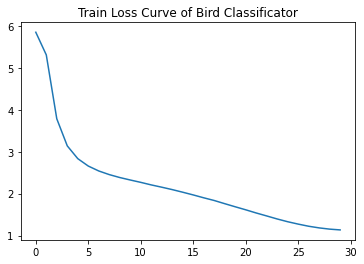

In [17]:
import matplotlib.pyplot as plt

train_losses = torch.tensor(train_losses, device = 'cpu')
plt.plot(np.arange(len(train_losses)), train_losses)
plt.title('Train Loss Curve of Bird Classificator')

Text(0.5, 1.0, 'Validation Accuracy Curve of Bird Classificator')

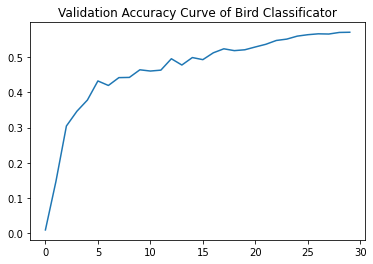

In [18]:
val_losses = torch.tensor(val_losses, device = 'cpu')
plt.plot(np.arange(len(val_losses)), val_losses)
plt.title('Validation Accuracy Curve of Bird Classificator')

Text(0.5, 1.0, 'Log-score Curve of Bird Classificator')

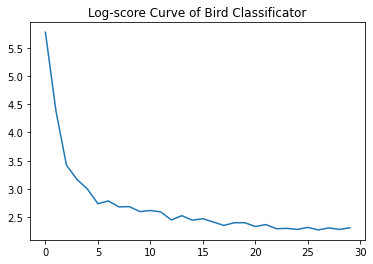

In [19]:
log_scores = torch.tensor(log_scores, device = 'cpu')
plt.plot(np.arange(len(log_scores)), log_scores)
plt.title('Log-score Curve of Bird Classificator')

Text(0.5, 1.0, 'F-beta score Curve of Bird Classificator')

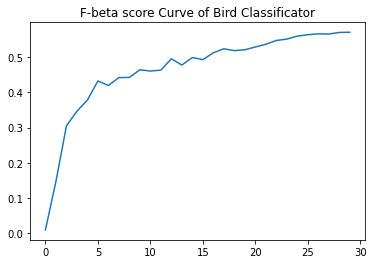

In [20]:
fbeta_scores = torch.tensor(fbeta_scores, device = 'cpu')
plt.plot(np.arange(len(fbeta_scores)), fbeta_scores)
plt.title('F-beta score Curve of Bird Classificator')

In [21]:
print('\nAccuracy: %.2f' % (100 * test_scores[0]))
print('Log Loss score:\t%.2f' % (test_scores[1]))
print('Fbeta-score (beta=1.0): \t%.2f' % (test_scores[2]))


Accuracy: 56.95
Log Loss score:	2.33
Fbeta-score (beta=1.0): 	0.57
